In [1]:
from typing import Dict, Tuple
import os

import torch
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.agents.callbacks import DefaultCallbacks
from ray.rllib.env import BaseEnv
from ray.rllib.evaluation import Episode, RolloutWorker
from ray.rllib.policy import Policy
from ray.rllib.policy.sample_batch import SampleBatch

import gym
from gym import wrappers
import ray
import numpy as np
from scipy.interpolate import interp1d
import pickle

import matplotlib.pyplot as plt
from torchsummary import summary

import io
import base64
from IPython.display import HTML

from src.envs.multiple_particles_in_flow_continuous import MultipleParticlesInFlowContinuous
from src.envs.multiple_particles_in_flow_discrete import MultipleParticlesInFlowDiscrete
from src.envs.multiple_particles_in_flow_delayed_obs_continuous import MultipleParticlesInFlowDelayedObsContinuous
from src.envs.multiple_particles_in_flow_delayed_obs_discrete import MultipleParticlesInFlowDelayedObsDiscrete

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Useful Functions

In [2]:
def test_and_plot(env, policy, lstm=False):
    obs = env.reset()
    done = False
    total_reward = 0
    step = 0

    obs_hist = [obs]
    particle_hist = [env.cur_particles]
    state_hist = [env.cur_state]
    action_hist = []
    if lstm:
        lstm_state = [np.zeros([lstm_cell_size], np.float32) for _ in range(2)]
        lstm_state_hist = [lstm_state]
    action = [0]

    while not done:
        if lstm:
            action, lstm_state, _ = policy(obs, lstm_state, explore=False)
        else:
            action = policy(obs, explore=False)
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        step += 1
        obs_hist.append(obs)
        action_hist.append(action)
        particle_hist.append(env.cur_particles)
        state_hist.append(env.cur_state)
        if lstm:
            lstm_state_hist.append(lstm_state)

    print(f"Played 1 episode; total-reward={total_reward}; Number of steps: {step}")

    particle_hist = np.array(particle_hist)
    state_hist = np.array(state_hist)
    action_hist = np.array(action_hist)
    obs_hist = np.array(obs_hist)

    act_x, act_y = np.meshgrid(np.linspace(0,15,151),np.linspace(0,1.2,15))
    act_mag = env.jet_dist(act_x, act_y)

    fig = plt.figure(figsize=(16,8))

    ax = fig.add_subplot(211)
    ax.plot(particle_hist[:,:,0], particle_hist[:,:,1], c='r', lw=0.1)
    ax.scatter(particle_hist[0,:,0], particle_hist[0,:,1], s=5, c='r')
    ax.scatter(particle_hist[-1,:,0], particle_hist[-1,:,1], s=5, c='r')
    ax.plot(state_hist[:,0], state_hist[:,1], c='darkred', lw=2)
    # ax.plot(obs_hist[:,0], obs_hist[:,1], c='r', label='Observation')
    # ax.plot(action_region_x, action_region_y, c='orange', label='Force Field')
    ax.contourf(act_x, act_y, act_mag, vmin=-1.6, vmax=1.5, cmap='RdBu', zorder=-10)
    ax.plot(state_hist[:-1,0], action_hist, c='k', label='Action')
    ax.grid(True)
    ax.set_aspect('equal', 'box')
    ax.set_xlim([0,15])
    ax.set_ylim([0,1.2])

    ax = fig.add_subplot(212)
    ax.plot(action_hist, c='k', label='Action')
    ax.plot(state_hist[:-1,1], c='darkred', label='Mean y')
    ax.plot(obs_hist, c='b', label='Action')
    ax.set_xlim([0,200])
    ax.set_ylim([0,1.2])
    ax.grid()
    
    return ax

In [3]:
def plot_results(train_episodes, train_reward, train_downwash, train_actuation):
    fig = plt.figure(figsize=[16,4])
    ax = fig.add_subplot(131)
    ax.plot(train_episodes, train_reward, c='r', label='Average Reward')
    ax.legend()
    ax.grid()

    ax = fig.add_subplot(132)
    ax.plot(train_episodes, train_downwash, c='b', label='Average Downwash')
    ax.legend()
    ax.grid()

    ax = fig.add_subplot(133)
    ax.plot(train_episodes, train_actuation, c='k', label='Average Actuation')
    ax.legend()
    ax.grid()
    
    return ax

In [4]:
def const_policy_cont(a, explore=False):
    return [1]
def const_policy_disc(a, explore=False):
    return 1

## Callbacks

In [5]:
class MyCallbacks(DefaultCallbacks):
    def on_episode_start(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: Episode,
        env_index: int,
        **kwargs
    ):
        # Make sure this episode has just been started (only initial obs
        # logged so far).
        assert episode.length == 0, (
            "ERROR: `on_episode_start()` callback should be called right "
            "after env reset!"
        )
        episode.user_data["reward_downwash"] = []
        episode.hist_data["reward_downwash"] = []
        episode.user_data["reward_actuation"] = []
        episode.hist_data["reward_actuation"] = []
        
    def on_episode_step(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: Episode,
        env_index: int,
        **kwargs
    ):
        # Make sure this episode is ongoing.
        assert episode.length > 0, (
            "ERROR: `on_episode_step()` callback should not be called right "
            "after env reset!"
        )
        reward_downwash = base_env.get_sub_environments()[0].cur_reward_downwash
        reward_actuation = -base_env.get_sub_environments()[0].cur_reward_actuation

        episode.user_data["reward_downwash"].append(reward_downwash)
        episode.user_data["reward_actuation"].append(reward_actuation)

    def on_episode_end(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: Episode,
        env_index: int,
        **kwargs
    ):
        # Check if there are multiple episodes in a batch, i.e.
        # "batch_mode": "truncate_episodes".
        if worker.policy_config["batch_mode"] == "truncate_episodes":
            # Make sure this episode is really done.
            assert episode.batch_builder.policy_collectors["default_policy"].batches[
                -1
            ]["dones"][-1], (
                "ERROR: `on_episode_end()` should only be called "
                "after episode is done!"
            )
        reward_downwash = np.mean(episode.user_data["reward_downwash"])
        reward_actuation = np.mean(episode.user_data["reward_actuation"])

        episode.custom_metrics["reward_downwash"] = reward_downwash
        episode.custom_metrics["reward_actuation"] = reward_actuation
        episode.hist_data["reward_downwash"] = episode.user_data["reward_downwash"]
        episode.hist_data["reward_actuation"] = episode.user_data["reward_actuation"]

---------------------------------------------------------------------
# Shoot down MULTIPLE particle - Partially Observed - Maximize Downwash
---------------------------------------------------------------------

## Global Configurations

## PPO + LSTM - Discrete - W = 5

2022-05-08 02:04:27,713	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
(RolloutWorker pid=840) 2022-05-08 02:04:33,071	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=840) 2022-05-08 02:04:33,071	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(Rollou

2022-05-08 02:04:40,302	INFO rnn_sequencing.py:145 -- Padded input for RNN/Attn.Nets/MA:

{ 'features': [ [ np.ndarray((2240, 1), dtype=float32, min=0.0, max=0.757, mean=0.057)],
                [ np.ndarray((2240, 1), dtype=float32, min=0.0, max=0.757, mean=0.057)],
                [ np.ndarray((2240,), dtype=int32, min=0.0, max=1.0, mean=0.507)],
                [ np.ndarray((2240,), dtype=float32, min=-5.0, max=36.813, mean=2.267)],
                [ np.ndarray((2240,), dtype=bool, min=0.0, max=1.0, mean=0.005)],
                [ np.ndarray((2240,), dtype=int64, min=0.0, max=1940455119.0, mean=1033005037.792)],
                [ np.ndarray((2240,), dtype=int64, min=0.0, max=6.0, mean=2.696)],
                [ np.ndarray((2240,), dtype=int64, min=0.0, max=0.0, mean=0.0)],
                [ np.ndarray((2240,), dtype=float32, min=-0.1, max=0.16, mean=-0.05)],
                [ np.ndarray((2240, 2), dtype=float32, min=-0.673, max=0.078, mean=-0.207)],
                [ np.ndarray((224

i=0; reward=344.4008432473379; downwash=5.097379491673821; actuation=0.5575048020193201; episodes=12; total episodes=12
i=1; reward=396.833113798065; downwash=5.50581865507077; actuation=0.5697523281663047; episodes=14; total episodes=26
i=2; reward=398.0516056832247; downwash=5.472705873749684; actuation=0.5654407931377268; episodes=14; total episodes=40
i=3; reward=389.98014581398854; downwash=5.344486065922507; actuation=0.547548281502438; episodes=14; total episodes=54
i=4; reward=387.00048580170727; downwash=5.2904290131686995; actuation=0.5395725058019379; episodes=14; total episodes=68
i=5; reward=391.2366250654222; downwash=5.2954370097854495; actuation=0.5361936667734624; episodes=13; total episodes=81
i=6; reward=404.42718461278537; downwash=5.477626934496959; actuation=0.553810902620563; episodes=13; total episodes=94
i=7; reward=417.5370621365608; downwash=5.639031844849426; actuation=0.5700931878532521; episodes=14; total episodes=108
i=8; reward=424.8796053040992; downwas

i=68; reward=674.7259128303715; downwash=5.291351268710519; actuation=0.18072176043598873; episodes=14; total episodes=924
i=69; reward=665.1014582185472; downwash=5.202572618485118; actuation=0.17125142241653635; episodes=13; total episodes=937
i=70; reward=664.7630732268599; downwash=5.17886306184204; actuation=0.16569466477060868; episodes=14; total episodes=951
i=71; reward=658.0976089987402; downwash=5.111241765472047; actuation=0.15721466568317038; episodes=13; total episodes=964
i=72; reward=659.3076845105195; downwash=5.110526424870426; actuation=0.15645094569499104; episodes=13; total episodes=977
i=73; reward=709.9282053108649; downwash=5.49468107748852; actuation=0.1700389770251704; episodes=14; total episodes=991
i=74; reward=730.3641043015958; downwash=5.669090923020678; actuation=0.1781785518735025; episodes=13; total episodes=1004
i=75; reward=722.5757179049231; downwash=5.6358005752791565; actuation=0.17910266717572657; episodes=13; total episodes=1017
i=76; reward=712.

i=135; reward=755.7207685018127; downwash=6.322658986459766; actuation=0.28185862335786366; episodes=14; total episodes=1823
i=136; reward=746.9342990121119; downwash=6.214720663722505; actuation=0.267981849678559; episodes=13; total episodes=1836
i=137; reward=742.6125705563776; downwash=6.136741520813831; actuation=0.2607435944383295; episodes=13; total episodes=1849
i=138; reward=752.5838125636781; downwash=6.1737881372145536; actuation=0.25772885520030353; episodes=14; total episodes=1863
i=139; reward=748.7084566098072; downwash=6.118138547682155; actuation=0.24861488963566333; episodes=13; total episodes=1876
i=140; reward=751.5584819174834; downwash=6.0984249229249725; actuation=0.2394423429192464; episodes=14; total episodes=1890
i=141; reward=752.87267648813; downwash=5.979942864202991; actuation=0.21244409825881502; episodes=12; total episodes=1902
i=142; reward=766.7305686362796; downwash=6.049456075672233; actuation=0.20963262554885823; episodes=14; total episodes=1916
i=14

i=201; reward=763.347196674193; downwash=6.435265062922725; actuation=0.29950763384426216; episodes=12; total episodes=2693
i=202; reward=772.9111925201971; downwash=6.441660697053277; actuation=0.2901990514061008; episodes=14; total episodes=2707
i=203; reward=775.0656842334517; downwash=6.390038661807861; actuation=0.272961181628039; episodes=14; total episodes=2721
i=204; reward=774.553467349554; downwash=6.366216593381962; actuation=0.2692154724846839; episodes=13; total episodes=2734
i=205; reward=778.3089284372196; downwash=6.324051918766571; actuation=0.2571948615028816; episodes=13; total episodes=2747
i=206; reward=783.6061152516085; downwash=6.327854629586202; actuation=0.24982782168788906; episodes=13; total episodes=2760
i=207; reward=784.0579218305804; downwash=6.273933434049772; actuation=0.23744136725181156; episodes=14; total episodes=2774
i=208; reward=780.3607232440122; downwash=6.239571738815763; actuation=0.23405047640835183; episodes=13; total episodes=2787
i=209; 

i=267; reward=875.1848091346706; downwash=7.067319332808271; actuation=0.2860495323605626; episodes=12; total episodes=3560
i=268; reward=863.6207165783753; downwash=7.140887972657557; actuation=0.3148001813485992; episodes=14; total episodes=3574
i=269; reward=851.5223119055332; downwash=7.186834671647455; actuation=0.34431941497178087; episodes=12; total episodes=3586
i=270; reward=830.6033957493486; downwash=7.223725653437003; actuation=0.3751958436419378; episodes=14; total episodes=3600
i=271; reward=817.6137456257094; downwash=7.238157137437466; actuation=0.3950394205675491; episodes=13; total episodes=3613
i=272; reward=811.3773692415307; downwash=7.313994492759398; actuation=0.4171602441292272; episodes=13; total episodes=3626
i=273; reward=804.1098516541809; downwash=7.408991903533213; actuation=0.4469628198040074; episodes=13; total episodes=3639
i=274; reward=781.7683257786231; downwash=7.40962549527522; actuation=0.4796763969912993; episodes=13; total episodes=3652
i=275; r

i=333; reward=785.9174074198376; downwash=7.3771033236462005; actuation=0.47900407105502224; episodes=13; total episodes=4418
i=334; reward=788.8176158200096; downwash=7.40819248104084; actuation=0.4796176124135837; episodes=13; total episodes=4431
i=335; reward=785.2591553866982; downwash=7.224012524895823; actuation=0.4500869256226223; episodes=13; total episodes=4444
i=336; reward=793.4401730027428; downwash=7.257427066858035; actuation=0.4446770935561706; episodes=13; total episodes=4457
i=337; reward=794.047807535152; downwash=7.213651231062718; actuation=0.4370510287021703; episodes=13; total episodes=4470
i=338; reward=798.988254403987; downwash=7.172927047947191; actuation=0.4160257389997649; episodes=13; total episodes=4483
i=339; reward=816.292131727351; downwash=7.106816177465926; actuation=0.38081081142565393; episodes=13; total episodes=4496
i=340; reward=818.014307224356; downwash=6.941640027077561; actuation=0.33619091734891327; episodes=14; total episodes=4510
i=341; re

2022-05-08 02:40:55,293	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 02:40:55,293	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=867.784037293944; downwash=7.210542947938904; actuation=0.32812091341740995; episodes=14; total episodes=5280


(RolloutWorker pid=1532) 2022-05-08 02:40:56,693	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=1532) 2022-05-08 02:40:56,693	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=1532) 2022-05-08 02:40:56,723	INFO torch_policy.py:183 -- TorchPolicy (worker=1) running on CPU.
2022-05-08 02:40:56,734	INFO worker_set.py:154 -- Inferred observation/action spaces from remote worker (local worker has 

(RolloutWorker pid=1532) 2022-05-08 02:40:57,973	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=1532) 
(RolloutWorker pid=1532) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.373, max=0.104, mean=0.002),
(RolloutWorker pid=1532)   'action_logp': np.ndarray((1024,), dtype=float32, min=-0.913, max=-0.512, mean=-0.692),
(RolloutWorker pid=1532)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.525),
(RolloutWorker pid=1532)   'advantages': np.ndarray((1024,), dtype=float32, min=-55.871, max=567.84, mean=187.815),
(RolloutWorker pid=1532)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=1532)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=1532)   'eps_id': np.ndarray((1024,), dtype=int64, min=1239764374.0, max=1916954656.0, mean=1558521366.112),
(RolloutWorker pid=1532)   'infos': np.ndarray((1024,), dtype=object, head={}),
(Roll

i=0; reward=314.07066474316713; downwash=4.728495537472951; actuation=0.5237784792474222; episodes=12; total episodes=12
i=1; reward=334.8249817795892; downwash=4.83704300657598; actuation=0.5161582052137607; episodes=14; total episodes=26
i=2; reward=343.2767476708046; downwash=4.806631649808532; actuation=0.5030898948979785; episodes=14; total episodes=40
i=3; reward=341.1578195088882; downwash=4.706308338472824; actuation=0.48750029327399813; episodes=14; total episodes=54
i=4; reward=325.3640397221952; downwash=4.5192828148776405; actuation=0.4700524141917605; episodes=14; total episodes=68
i=5; reward=319.17860864330817; downwash=4.435221689737108; actuation=0.46197665164554236; episodes=13; total episodes=81
i=6; reward=321.89046447805816; downwash=4.483234251647003; actuation=0.46712933003046525; episodes=13; total episodes=94
i=7; reward=310.05780058153135; downwash=4.310241101490768; actuation=0.44803626086205084; episodes=15; total episodes=109
i=8; reward=291.7996464542156; 

i=68; reward=663.5392122890388; downwash=5.84000111446658; actuation=0.2924282080200159; episodes=13; total episodes=936
i=69; reward=649.9943720648694; downwash=5.69983095750048; actuation=0.28481812718613847; episodes=13; total episodes=949
i=70; reward=635.3182614768746; downwash=5.626664866622755; actuation=0.28891617201497477; episodes=14; total episodes=963
i=71; reward=635.032735362308; downwash=5.68196368082638; actuation=0.3026007713843044; episodes=13; total episodes=976
i=72; reward=641.3488592821574; downwash=5.821363750831697; actuation=0.3258975498277901; episodes=13; total episodes=989
i=73; reward=634.5005285205042; downwash=5.8591535999537845; actuation=0.347424613177187; episodes=14; total episodes=1003
i=74; reward=645.3874636869781; downwash=6.015787833834199; actuation=0.36384629775963717; episodes=12; total episodes=1015
i=75; reward=627.8709985407054; downwash=6.056928704814347; actuation=0.39474904293620455; episodes=14; total episodes=1029
i=76; reward=630.1217

i=135; reward=813.815355937836; downwash=6.891053065111529; actuation=0.3385878552307872; episodes=12; total episodes=1820
i=136; reward=802.897995465605; downwash=6.887976384147704; actuation=0.34825236954780975; episodes=14; total episodes=1834
i=137; reward=795.8401794809449; downwash=6.909640924490045; actuation=0.3596591625783364; episodes=14; total episodes=1848
i=138; reward=784.7645715695414; downwash=6.850179629500608; actuation=0.3620011501093197; episodes=12; total episodes=1860
i=139; reward=776.2226310322962; downwash=6.829877897650476; actuation=0.36672760651464675; episodes=14; total episodes=1874
i=140; reward=773.021648768035; downwash=6.824347129609837; actuation=0.3648840089214508; episodes=13; total episodes=1887
i=141; reward=764.4241188866786; downwash=6.768362539686567; actuation=0.36193561597103746; episodes=13; total episodes=1900
i=142; reward=760.3960170247274; downwash=6.756925560447295; actuation=0.3658580016662555; episodes=13; total episodes=1913
i=143; r

i=202; reward=731.6796296126006; downwash=7.212723404589027; actuation=0.498782794588021; episodes=14; total episodes=2703
i=203; reward=737.3257950704741; downwash=7.043488043202674; actuation=0.4594077097697744; episodes=13; total episodes=2716
i=204; reward=738.9446190054982; downwash=6.911788382227753; actuation=0.4323790608116177; episodes=13; total episodes=2729
i=205; reward=758.3163801436853; downwash=6.8962359204892065; actuation=0.40293575481887345; episodes=13; total episodes=2742
i=206; reward=776.3048121755866; downwash=6.8578140569520905; actuation=0.3691711927001788; episodes=13; total episodes=2755
i=207; reward=796.5011804153256; downwash=6.820116027426816; actuation=0.3347103650594115; episodes=14; total episodes=2769
i=208; reward=815.291110010554; downwash=6.8018105577126; actuation=0.3064529318826016; episodes=12; total episodes=2781
i=209; reward=841.4398434902237; downwash=6.8867447343595165; actuation=0.2904405564001173; episodes=14; total episodes=2795
i=210; r

i=268; reward=704.013165326788; downwash=7.394002666666216; actuation=0.5845964013141229; episodes=14; total episodes=3566
i=269; reward=708.4181406201786; downwash=7.4279025083178745; actuation=0.5839949212041194; episodes=12; total episodes=3578
i=270; reward=718.6897960095665; downwash=7.490192199767347; actuation=0.5803694351975414; episodes=14; total episodes=3592
i=271; reward=718.915704931078; downwash=7.468598753022471; actuation=0.578128929512089; episodes=12; total episodes=3604
i=272; reward=716.3957520850819; downwash=7.43793540984507; actuation=0.5754764212063617; episodes=13; total episodes=3617
i=273; reward=722.9675375086425; downwash=7.455815040603644; actuation=0.5719806145444867; episodes=13; total episodes=3630
i=274; reward=726.4436020816329; downwash=7.445692207701682; actuation=0.5663603040567369; episodes=13; total episodes=3643
i=275; reward=728.8001865536775; downwash=7.451328270023392; actuation=0.5622379275724648; episodes=13; total episodes=3656
i=276; rewa

i=335; reward=776.565616958716; downwash=7.5930743504145655; actuation=0.5284361306366785; episodes=13; total episodes=4436
i=336; reward=779.7161337225573; downwash=7.6241428497403145; actuation=0.5310381083833926; episodes=13; total episodes=4449
i=337; reward=802.1739089346542; downwash=7.635281444481634; actuation=0.504704466786959; episodes=13; total episodes=4462
i=338; reward=806.5970911813647; downwash=7.567062034130973; actuation=0.4866712618101453; episodes=13; total episodes=4475
i=339; reward=816.4226759480922; downwash=7.431950578871462; actuation=0.4486973883915579; episodes=13; total episodes=4488
i=340; reward=822.1961129570614; downwash=7.282904436324603; actuation=0.41293096852688216; episodes=13; total episodes=4501
i=341; reward=814.76640945026; downwash=7.2544747847086235; actuation=0.41800553729795525; episodes=12; total episodes=4513
i=342; reward=802.7904282889507; downwash=7.269130775811352; actuation=0.4366975240557253; episodes=13; total episodes=4526
i=343; 

2022-05-08 03:17:23,997	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 03:17:23,998	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=875.544227084352; downwash=7.278489176928958; actuation=0.33624069225449493; episodes=13; total episodes=5264


2022-05-08 03:17:25,453	INFO worker_set.py:154 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([0.], [1.], (1,), float64), Discrete(2)), '__env__': (Box([0.], [1.], (1,), float64), Discrete(2))}
2022-05-08 03:17:25,458	INFO torch_policy.py:206 -- TorchPolicy (worker=local) running on 1 GPU(s).
(RolloutWorker pid=2154) 2022-05-08 03:17:25,410	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=2154) 2022-05-08 03:17:25,410	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or 

(RolloutWorker pid=2154) 2022-05-08 03:17:26,701	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=2154) 
(RolloutWorker pid=2154) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.207, max=0.005, mean=-0.159),
(RolloutWorker pid=2154)   'action_logp': np.ndarray((1024,), dtype=float32, min=-0.746, max=-0.64, mean=-0.693),
(RolloutWorker pid=2154)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.492),
(RolloutWorker pid=2154)   'advantages': np.ndarray((1024,), dtype=float32, min=-99.81, max=616.88, mean=199.151),
(RolloutWorker pid=2154)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=2154)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=2154)   'eps_id': np.ndarray((1024,), dtype=int64, min=132104106.0, max=1489767324.0, mean=677569166.769),
(RolloutWorker pid=2154)   'infos': np.ndarray((1024,), dtype=object, head={}),
(Rollout

i=0; reward=386.08274676489924; downwash=5.069838083986491; actuation=0.4980175937153467; episodes=13; total episodes=13
i=1; reward=396.85914329872105; downwash=5.221184776381391; actuation=0.5187067419179802; episodes=13; total episodes=26
i=2; reward=389.548211053396; downwash=5.116776445087167; actuation=0.510516803379915; episodes=13; total episodes=39
i=3; reward=399.0744658081988; downwash=5.203779227943451; actuation=0.514633730663994; episodes=14; total episodes=53
i=4; reward=424.9255972224613; downwash=5.481673057257231; actuation=0.5365304291874272; episodes=13; total episodes=66
i=5; reward=442.2191469821337; downwash=5.759144258319551; actuation=0.572308606837727; episodes=14; total episodes=80
i=6; reward=449.1950176474039; downwash=5.9757351305286095; actuation=0.6063768084987253; episodes=13; total episodes=93
i=7; reward=452.30984533514317; downwash=6.179741594514184; actuation=0.642656998979957; episodes=13; total episodes=106
i=8; reward=475.1073904051401; downwash=

i=68; reward=775.685223009246; downwash=6.994259916042497; actuation=0.407137045664009; episodes=13; total episodes=901
i=69; reward=778.328036705642; downwash=7.0440513654561; actuation=0.4118597209659813; episodes=13; total episodes=914
i=70; reward=785.5403550292791; downwash=7.088064591868255; actuation=0.41223715356874796; episodes=13; total episodes=927
i=71; reward=791.5430777696223; downwash=7.210764502854009; actuation=0.4297291720679447; episodes=13; total episodes=940
i=72; reward=789.6592038856033; downwash=7.206428105395345; actuation=0.43143850148571994; episodes=13; total episodes=953
i=73; reward=797.5587813795723; downwash=7.254793134011098; actuation=0.43029184842218177; episodes=13; total episodes=966
i=74; reward=796.796204586742; downwash=7.2508591192834055; actuation=0.43031697544119074; episodes=13; total episodes=979
i=75; reward=804.9173977546766; downwash=7.301245389874631; actuation=0.429862398962822; episodes=13; total episodes=992
i=76; reward=809.673848899

i=135; reward=801.0629528350713; downwash=7.387610814221238; actuation=0.4532622083168839; episodes=14; total episodes=1771
i=136; reward=799.285997508918; downwash=7.379045327354171; actuation=0.4502213091003105; episodes=12; total episodes=1783
i=137; reward=758.3157594121544; downwash=7.374984530222754; actuation=0.5027988526874327; episodes=14; total episodes=1797
i=138; reward=717.4564508505566; downwash=7.33250174391633; actuation=0.5508045749799995; episodes=12; total episodes=1809
i=139; reward=687.8262683473362; downwash=7.345467588577546; actuation=0.5924719378243006; episodes=13; total episodes=1822
i=140; reward=696.9889533320008; downwash=7.385420890427534; actuation=0.5857413582996959; episodes=13; total episodes=1835
i=141; reward=698.8910633648493; downwash=7.2559312908065605; actuation=0.5599523512483057; episodes=13; total episodes=1848
i=142; reward=708.2879025407103; downwash=7.287681131566972; actuation=0.5521412006549429; episodes=13; total episodes=1861
i=143; re

i=201; reward=785.6867178899038; downwash=7.403792069781833; actuation=0.490593669835348; episodes=14; total episodes=2631
i=202; reward=790.6309080858091; downwash=7.433240569908488; actuation=0.4880632088019816; episodes=12; total episodes=2643
i=203; reward=789.9258164321504; downwash=7.417279037244757; actuation=0.4806716976817365; episodes=14; total episodes=2657
i=204; reward=792.6231926789667; downwash=7.322012331826931; actuation=0.45602481405074186; episodes=13; total episodes=2670
i=205; reward=810.2891218573325; downwash=7.28424238197759; actuation=0.42479241502718124; episodes=13; total episodes=2683
i=206; reward=810.9945044105604; downwash=7.190374591970705; actuation=0.4066894944598803; episodes=12; total episodes=2695
i=207; reward=821.540188574097; downwash=7.180030235716571; actuation=0.3893690987719463; episodes=14; total episodes=2709
i=208; reward=809.1692496149976; downwash=7.168905113715123; actuation=0.4048618725907271; episodes=12; total episodes=2721
i=209; re

i=268; reward=844.2385468339618; downwash=6.866832524889695; actuation=0.288896535639057; episodes=14; total episodes=3502
i=269; reward=832.0578801382399; downwash=6.783880009450989; actuation=0.28255539337093394; episodes=12; total episodes=3514
i=270; reward=813.6924271798766; downwash=6.618361566743005; actuation=0.273661415006472; episodes=14; total episodes=3528
i=271; reward=796.7253755193943; downwash=6.490496844769192; actuation=0.2642558496968183; episodes=14; total episodes=3542
i=272; reward=808.2960502481541; downwash=6.607091077625861; actuation=0.2722982782561779; episodes=12; total episodes=3554
i=273; reward=812.9233734617715; downwash=6.661380230900395; actuation=0.277067694761784; episodes=14; total episodes=3568
i=274; reward=818.0913686883147; downwash=6.684470427407597; actuation=0.28138343268746796; episodes=12; total episodes=3580
i=275; reward=837.1784539257794; downwash=6.843898538541791; actuation=0.28797167736918683; episodes=14; total episodes=3594
i=276; r

i=334; reward=741.6460080990109; downwash=7.647228503123497; actuation=0.5879609782959538; episodes=12; total episodes=4358
i=335; reward=712.1457727904384; downwash=7.598396044454794; actuation=0.6151114333490629; episodes=14; total episodes=4372
i=336; reward=703.7404542346588; downwash=7.620770555039086; actuation=0.6297072556598932; episodes=12; total episodes=4384
i=337; reward=704.721849249529; downwash=7.627768475448945; actuation=0.6307827937435604; episodes=12; total episodes=4396
i=338; reward=696.4590189027376; downwash=7.574866361693004; actuation=0.6318793236607974; episodes=14; total episodes=4410
i=339; reward=702.6869400764981; downwash=7.591706800510807; actuation=0.628443240947247; episodes=12; total episodes=4422
i=340; reward=705.1275997422002; downwash=7.571896302772817; actuation=0.6231277702824766; episodes=13; total episodes=4435
i=341; reward=698.1327922003447; downwash=7.514557216348871; actuation=0.6225610496451168; episodes=13; total episodes=4448
i=342; rew

2022-05-08 03:53:49,738	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 03:53:49,739	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=875.5888981846861; downwash=7.543529589225998; actuation=0.3891522139580189; episodes=12; total episodes=5202


2022-05-08 03:53:51,178	INFO worker_set.py:154 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([0.], [1.], (1,), float64), Discrete(2)), '__env__': (Box([0.], [1.], (1,), float64), Discrete(2))}
2022-05-08 03:53:51,182	INFO torch_policy.py:206 -- TorchPolicy (worker=local) running on 1 GPU(s).
2022-05-08 03:53:51,194	INFO rollout_worker.py:1727 -- Built policy map: {}
2022-05-08 03:53:51,194	INFO rollout_worker.py:1728 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7efc10614e20>}
2022-05-08 03:53:51,195	INFO rollout_worker.py:666 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7efc10614d00>}
(RolloutWorker pid=2776) 2022-05-08 03:53:51,138	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You 

(RolloutWorker pid=2776) 2022-05-08 03:53:52,450	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=2776) 
(RolloutWorker pid=2776) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.781, max=0.034, mean=-0.116),
(RolloutWorker pid=2776)   'action_logp': np.ndarray((1024,), dtype=float32, min=-1.048, max=-0.433, mean=-0.689),
(RolloutWorker pid=2776)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.494),
(RolloutWorker pid=2776)   'advantages': np.ndarray((1024,), dtype=float32, min=-50.107, max=630.23, mean=172.206),
(RolloutWorker pid=2776)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=2776)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=2776)   'eps_id': np.ndarray((1024,), dtype=int64, min=51821048.0, max=1412417196.0, mean=721179809.464),
(RolloutWorker pid=2776)   'infos': np.ndarray((1024,), dtype=object, head={}),
(Rollou

i=0; reward=320.41359150205403; downwash=4.54543527246324; actuation=0.4840191792451949; episodes=12; total episodes=12
i=1; reward=338.82954419363244; downwash=4.8445998221390925; actuation=0.5142665032741385; episodes=14; total episodes=26
i=2; reward=377.7899016058555; downwash=5.264841933467142; actuation=0.5490333484930534; episodes=14; total episodes=40
i=3; reward=382.06625717607056; downwash=5.2598299609092125; actuation=0.5445512441706462; episodes=14; total episodes=54
i=4; reward=377.19419362769713; downwash=5.242282049889505; actuation=0.5445832190236038; episodes=14; total episodes=68
i=5; reward=378.5757494131498; downwash=5.255184772318006; actuation=0.5458147432769119; episodes=13; total episodes=81
i=6; reward=373.0461841107734; downwash=5.234867383568114; actuation=0.5477120882901353; episodes=14; total episodes=95
i=7; reward=384.4594939866598; downwash=5.340524928029051; actuation=0.5536976632218228; episodes=13; total episodes=108
i=8; reward=403.5001264403854; dow

i=68; reward=777.585333951499; downwash=7.602716418496118; actuation=0.5248255574280681; episodes=14; total episodes=901
i=69; reward=765.1751248094473; downwash=7.656666108035698; actuation=0.5478873599235485; episodes=12; total episodes=913
i=70; reward=762.2705668142687; downwash=7.6261480727617315; actuation=0.5478551847601794; episodes=13; total episodes=926
i=71; reward=761.6794711805221; downwash=7.5507031344536815; actuation=0.5381748005826232; episodes=13; total episodes=939
i=72; reward=779.6139923242965; downwash=7.545845700762382; actuation=0.514788580134158; episodes=13; total episodes=952
i=73; reward=792.2216990851; downwash=7.471353967365428; actuation=0.4855563297973569; episodes=13; total episodes=965
i=74; reward=806.848251874309; downwash=7.449337998793751; actuation=0.4629196471342841; episodes=13; total episodes=978
i=75; reward=826.8478891328136; downwash=7.434215108492961; actuation=0.43860159917579994; episodes=13; total episodes=991
i=76; reward=843.3089872598

i=135; reward=808.3806064502231; downwash=6.961154720429026; actuation=0.351007799419775; episodes=14; total episodes=1770
i=136; reward=816.8303194522701; downwash=6.996175967437885; actuation=0.3478031201938944; episodes=12; total episodes=1782
i=137; reward=831.5541900337515; downwash=7.075529149518367; actuation=0.35156440111760906; episodes=13; total episodes=1795
i=138; reward=830.986604155177; downwash=7.046270946152466; actuation=0.3469806545420915; episodes=13; total episodes=1808
i=139; reward=841.7330469105331; downwash=7.121477188916847; actuation=0.34629211566148277; episodes=13; total episodes=1821
i=140; reward=841.5548283386048; downwash=7.065508390940781; actuation=0.3366989237318444; episodes=14; total episodes=1835
i=141; reward=842.2287002049085; downwash=7.022262856108906; actuation=0.3304913204279461; episodes=12; total episodes=1847
i=142; reward=842.904769698196; downwash=7.006092844204153; actuation=0.32260177620835023; episodes=14; total episodes=1861
i=143; r

i=201; reward=830.6972809984981; downwash=7.480622291131219; actuation=0.437996091276595; episodes=13; total episodes=2632
i=202; reward=819.6841513176726; downwash=7.480522130887708; actuation=0.45355096813143203; episodes=13; total episodes=2645
i=203; reward=808.7465868549791; downwash=7.491319075629181; actuation=0.4695707904515755; episodes=13; total episodes=2658
i=204; reward=794.9336304161666; downwash=7.433341475272012; actuation=0.48084528693581224; episodes=13; total episodes=2671
i=205; reward=797.1270511448328; downwash=7.440605718430706; actuation=0.4790373336596621; episodes=12; total episodes=2683
i=206; reward=806.914033055342; downwash=7.4759335196398435; actuation=0.4708075148587927; episodes=14; total episodes=2697
i=207; reward=815.0762662563633; downwash=7.427540943883558; actuation=0.4483444874026146; episodes=14; total episodes=2711
i=208; reward=816.1626067873918; downwash=7.289349637335008; actuation=0.41394217878349593; episodes=12; total episodes=2723
i=209;

i=268; reward=876.2968883017354; downwash=7.230485382823461; actuation=0.33091683113639503; episodes=12; total episodes=3501
i=269; reward=881.7664684195793; downwash=7.280802678587984; actuation=0.3321900548283256; episodes=13; total episodes=3514
i=270; reward=888.6042897124597; downwash=7.345675723079197; actuation=0.3316417765797398; episodes=13; total episodes=3527
i=271; reward=881.9757942374969; downwash=7.297828108922675; actuation=0.33124559533054493; episodes=14; total episodes=3541
i=272; reward=889.5833046329656; downwash=7.3377049343332965; actuation=0.3313870208315355; episodes=12; total episodes=3553
i=273; reward=896.7519517564596; downwash=7.35639982765956; actuation=0.33013093984426606; episodes=14; total episodes=3567
i=274; reward=900.8537592272235; downwash=7.328001628711713; actuation=0.31981471204116013; episodes=12; total episodes=3579
i=275; reward=895.8471987462265; downwash=7.2573674972013285; actuation=0.3086437271855232; episodes=14; total episodes=3593
i=2

i=334; reward=739.2812243173295; downwash=7.579961312877231; actuation=0.5729583706823306; episodes=12; total episodes=4361
i=335; reward=752.3933229091515; downwash=7.575188615817003; actuation=0.5587103126662089; episodes=12; total episodes=4373
i=336; reward=753.0320683371609; downwash=7.3966600592239; actuation=0.5198957475830465; episodes=14; total episodes=4387
i=337; reward=754.8753726403198; downwash=7.184031600019486; actuation=0.4751896138555605; episodes=14; total episodes=4401
i=338; reward=776.2130448712646; downwash=7.143460673814263; actuation=0.4343190478208031; episodes=13; total episodes=4414
i=339; reward=798.4945634134322; downwash=7.1104564422218175; actuation=0.3986740700871046; episodes=13; total episodes=4427
i=340; reward=811.4979721962798; downwash=7.002759196146009; actuation=0.3591537395387497; episodes=13; total episodes=4440
i=341; reward=817.8045171768961; downwash=6.848154463339004; actuation=0.31909382270100045; episodes=13; total episodes=4453
i=342; r

2022-05-08 04:30:26,088	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 04:30:26,089	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=776.2006734196616; downwash=7.37526604930665; actuation=0.48316072850430913; episodes=14; total episodes=5207


2022-05-08 04:30:27,521	INFO worker_set.py:154 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([0.], [1.], (1,), float64), Discrete(2)), '__env__': (Box([0.], [1.], (1,), float64), Discrete(2))}
2022-05-08 04:30:27,527	INFO torch_policy.py:206 -- TorchPolicy (worker=local) running on 1 GPU(s).
2022-05-08 04:30:27,539	INFO rollout_worker.py:1727 -- Built policy map: {}
2022-05-08 04:30:27,540	INFO rollout_worker.py:1728 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7efc105b49a0>}
2022-05-08 04:30:27,540	INFO rollout_worker.py:666 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7efc1054d9d0>}
2022-05-08 04:30:27,546	WARNING util.py:60 -- Install gputil for GPU system monitoring.
(RolloutWorker pid=3441) 2022-05-08 04:30:27,506	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments.

(RolloutWorker pid=3440) 2022-05-08 04:30:28,746	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=3440) 
(RolloutWorker pid=3440) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.306, max=1.034, mean=0.011),
(RolloutWorker pid=3440)   'action_logp': np.ndarray((1024,), dtype=float32, min=-1.423, max=-0.275, mean=-0.653),
(RolloutWorker pid=3440)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.361),
(RolloutWorker pid=3440)   'advantages': np.ndarray((1024,), dtype=float32, min=-42.914, max=415.669, mean=118.364),
(RolloutWorker pid=3440)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=3440)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.007),
(RolloutWorker pid=3440)   'eps_id': np.ndarray((1024,), dtype=int64, min=20690087.0, max=1839597767.0, mean=780055637.608),
(RolloutWorker pid=3440)   'infos': np.ndarray((1024,), dtype=object, head={}),
(Rollou

i=0; reward=229.65744956997392; downwash=3.3443791637227225; actuation=0.35871879954634395; episodes=13; total episodes=13
i=1; reward=253.2494305847438; downwash=3.677082878245877; actuation=0.393969267956914; episodes=13; total episodes=26
i=2; reward=260.18294780127843; downwash=3.8132605772395705; actuation=0.4099686514402377; episodes=14; total episodes=40
i=3; reward=273.81492526438046; downwash=4.032306168846194; actuation=0.43530214787045085; episodes=14; total episodes=54
i=4; reward=272.925095205064; downwash=4.1550378720622065; actuation=0.46121564894164824; episodes=14; total episodes=68
i=5; reward=271.99958542097676; downwash=4.213504979878932; actuation=0.4746170156156311; episodes=14; total episodes=82
i=6; reward=260.3127613880835; downwash=4.184838597286183; actuation=0.4852154649728459; episodes=14; total episodes=96
i=7; reward=262.4304482131854; downwash=4.354323607316262; actuation=0.5173651056133083; episodes=14; total episodes=110
i=8; reward=265.0571378744304; 

i=68; reward=410.7497151852037; downwash=4.666984772215281; actuation=0.3889633222695136; episodes=12; total episodes=932
i=69; reward=390.59356116063225; downwash=4.3279231545693495; actuation=0.34589126752747495; episodes=15; total episodes=947
i=70; reward=372.4576236065631; downwash=3.98561357915333; actuation=0.299774144457873; episodes=14; total episodes=961
i=71; reward=395.4794480192153; downwash=4.047198974235183; actuation=0.28025575823314275; episodes=14; total episodes=975
i=72; reward=420.6448971305217; downwash=4.1975022204651005; actuation=0.27589506364483346; episodes=13; total episodes=988
i=73; reward=448.97027734436875; downwash=4.435487590257309; actuation=0.2881916228849596; episodes=14; total episodes=1002
i=74; reward=462.7982849577444; downwash=4.678133656781841; actuation=0.3200009115907196; episodes=13; total episodes=1015
i=75; reward=480.9003715627222; downwash=4.91800984676623; actuation=0.34422312822622736; episodes=13; total episodes=1028
i=76; reward=516

i=135; reward=503.9730549823847; downwash=5.629943987109514; actuation=0.45720127830910795; episodes=14; total episodes=1843
i=136; reward=514.5019254969062; downwash=5.610108801184591; actuation=0.4414564054861796; episodes=14; total episodes=1857
i=137; reward=516.1119623414528; downwash=5.6121966164104835; actuation=0.4402771523093642; episodes=14; total episodes=1871
i=138; reward=515.1081656919021; downwash=5.523284644240763; actuation=0.41943980731009184; episodes=14; total episodes=1885
i=139; reward=519.2546676542462; downwash=5.466785584936446; actuation=0.4017734926217941; episodes=13; total episodes=1898
i=140; reward=506.454547197999; downwash=5.399370060628904; actuation=0.40716017191737164; episodes=13; total episodes=1911
i=141; reward=505.6254663974844; downwash=5.436724833928558; actuation=0.4165170126188025; episodes=14; total episodes=1925
i=142; reward=496.93699536011366; downwash=5.472733661326656; actuation=0.43527590193092197; episodes=13; total episodes=1938
i=1

i=201; reward=741.6672449335987; downwash=6.441473189601103; actuation=0.3266657282088922; episodes=14; total episodes=2729
i=202; reward=747.5301388227381; downwash=6.560880253680942; actuation=0.34228137239205353; episodes=14; total episodes=2743
i=203; reward=750.6687716814724; downwash=6.634909273621577; actuation=0.3530612776453625; episodes=12; total episodes=2755
i=204; reward=764.3383323165217; downwash=6.819978891939903; actuation=0.37085003566132835; episodes=14; total episodes=2769
i=205; reward=767.9236365823873; downwash=6.858611805371089; actuation=0.37518835762102476; episodes=13; total episodes=2782
i=206; reward=783.7237739467386; downwash=6.951223728037498; actuation=0.3716493291861624; episodes=13; total episodes=2795
i=207; reward=791.6725345674603; downwash=6.902114530411049; actuation=0.3583125050370705; episodes=14; total episodes=2809
i=208; reward=797.6741636759514; downwash=6.8297139627498185; actuation=0.3364380468240407; episodes=12; total episodes=2821
i=20

i=267; reward=650.6818641098295; downwash=5.619417819736653; actuation=0.27239203350007524; episodes=14; total episodes=3612
i=268; reward=630.9111405794167; downwash=5.333817324758583; actuation=0.2385669807098463; episodes=13; total episodes=3625
i=269; reward=631.6172006528901; downwash=5.172366304276523; actuation=0.20350814699842154; episodes=14; total episodes=3639
i=270; reward=622.5013944497163; downwash=5.032420629551632; actuation=0.18586769243345594; episodes=13; total episodes=3652
i=271; reward=626.7256666906967; downwash=5.057983030275704; actuation=0.18371172732175622; episodes=13; total episodes=3665
i=272; reward=633.2331946224587; downwash=5.167280909562394; actuation=0.19467341380926395; episodes=14; total episodes=3679
i=273; reward=653.1683568539847; downwash=5.3629620056501395; actuation=0.21274438595560544; episodes=14; total episodes=3693
i=274; reward=670.1139125204974; downwash=5.548177851431206; actuation=0.23052974159031983; episodes=12; total episodes=3705


i=333; reward=748.221426694176; downwash=6.3600049182617715; actuation=0.30094419908297626; episodes=13; total episodes=4500
i=334; reward=745.2305896622555; downwash=6.329754515935088; actuation=0.2980353040480066; episodes=14; total episodes=4514
i=335; reward=745.1806004261903; downwash=6.307039328417731; actuation=0.28515393359413954; episodes=14; total episodes=4528
i=336; reward=742.3289704764994; downwash=6.250683804319343; actuation=0.27590130260060414; episodes=13; total episodes=4541
i=337; reward=745.7123358315871; downwash=6.209608399698956; actuation=0.2675333449300589; episodes=13; total episodes=4554
i=338; reward=736.9452105649646; downwash=6.10264002675312; actuation=0.2568857354116994; episodes=14; total episodes=4568
i=339; reward=741.2096707177369; downwash=6.054996266589038; actuation=0.24229645338544528; episodes=13; total episodes=4581
i=340; reward=743.0709006339472; downwash=6.012069106128522; actuation=0.22874320400721732; episodes=13; total episodes=4594
i=34

i=399; reward=678.2738358021328; downwash=6.274207796586521; actuation=0.37008901910579867; episodes=13; total episodes=5385


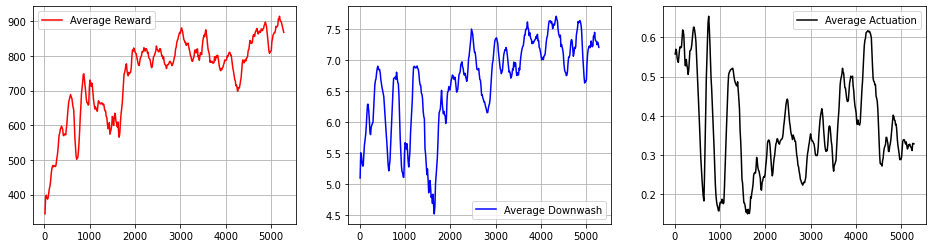

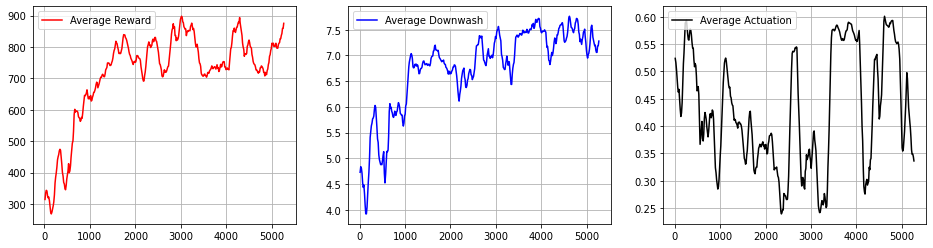

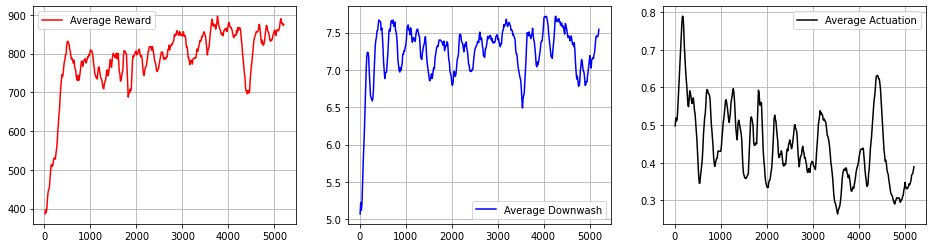

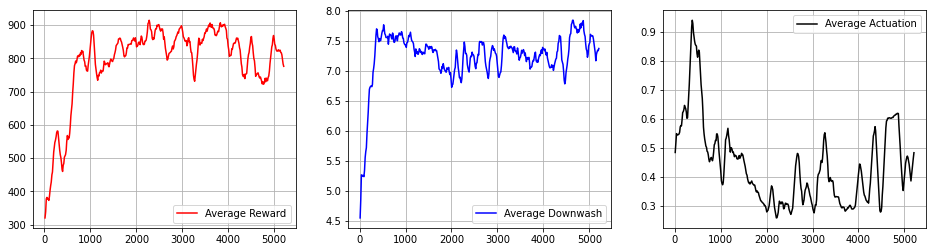

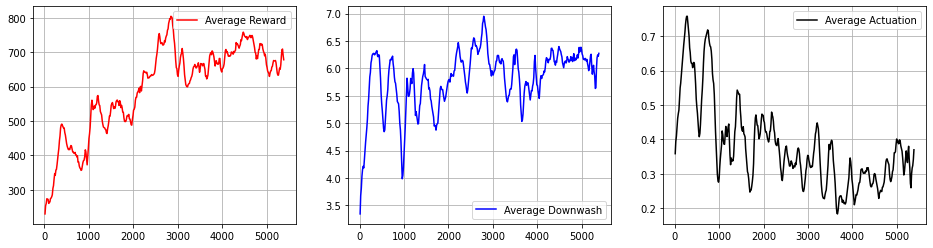

In [6]:
test_name = "act_cost_5_n_cells_1_1"

global_env_config = {
    "dt": 0.1,
    "xc": 9.0,
    "yc": 0.0,
    "sigma_x": 0.6,
    "sigma_y": 0.5,
    "gain": 0.25,
    "act_cost_weight": 5.0,
    "obs_min": [7.0, 0.1],
    "obs_max": [8.0, 0.5],
    "n_particles": 400,
    "lamb": 0.1,
    "n_cells": [1,1]
}

env_config = global_env_config.copy()

for random_seed in range(100,105):
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    lstm_cell_size = 16
    trainer_ppo_lstm_disc = PPOTrainer(
        config={
            "env": MultipleParticlesInFlowDiscrete,
            "env_config": env_config,
            "framework": "torch",
            "train_batch_size": 2*1024,
            "callbacks": MyCallbacks,
            # Parallel rollouts
    #         "num_workers": 8,
            "num_gpus": 1,
            "lr": 0.00005,
            "clip_param": 0.99,
            "log_level": "INFO",
            "model": {
                "use_lstm": True,
                "lstm_cell_size": lstm_cell_size,
                "lstm_use_prev_action": False,
                "lstm_use_prev_reward": False,
                "max_seq_len": 40,
                "fcnet_hiddens": [256, 256],
            },
        }
    )

    train_reward_hist_lstm_disc = []
    train_downwash_hist_lstm_disc = []
    train_actuation_hist_lstm_disc = []
    train_episodes_total_lstm_disc = []

    for i in range(400):
        results = trainer_ppo_lstm_disc.train()
        train_reward_hist_lstm_disc.append(results['episode_reward_mean'])
        train_downwash_hist_lstm_disc.append(results['custom_metrics']['reward_downwash_mean'])
        train_actuation_hist_lstm_disc.append(results['custom_metrics']['reward_actuation_mean'])
        train_episodes_total_lstm_disc.append(results['episodes_total'])
        print(f"i={i}; reward={results['episode_reward_mean']}; downwash={results['custom_metrics']['reward_downwash_mean']}; actuation={results['custom_metrics']['reward_actuation_mean']}; episodes={results['episodes_this_iter']}; total episodes={results['episodes_total']}")
        if i % 10 == 9:
            trainer_ppo_lstm_disc.save_checkpoint(trainer_ppo_lstm_disc.logdir)

    # Save results to file
    train_lstm_disc_results = {
        "train_reward": train_reward_hist_lstm_disc,
        "train_downwash": train_downwash_hist_lstm_disc,
        "train_actuation": train_actuation_hist_lstm_disc,
        "train_episodes": train_episodes_total_lstm_disc
    }

    filename = f"ray_results/ppo_lstm_discrete_{test_name}/train_results_{random_seed}.pkl"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as f:
        pickle.dump(train_lstm_disc_results, f)
    trainer_ppo_lstm_disc.save_checkpoint(f"ray_results/ppo_lstm_discrete_{test_name}")
    
    plot_results(train_episodes_total_lstm_disc, train_reward_hist_lstm_disc, train_downwash_hist_lstm_disc, train_actuation_hist_lstm_disc)
    

## PPO + LSTM - Discrete - W = 10

2022-05-08 05:06:58,818	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 05:06:58,819	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-05-08 05:07:00,282	INFO worker_set.py:154 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([0.], [1.], (1,), float64), Discrete(2)), '__env__': (Box([0.], [1.], (1,), float64), Discrete(2))}
2022-05-08 05:07:00,287	INFO torch_policy.py:206 -- TorchPolicy (worker=local) running on 1 GPU(s).
2022-05-08 05:07:00,300	INFO rollout_worker.py:1727 -- Built policy map: {}
2022-05-08 05:07:00,301	INFO rollout_worker.py:1728 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPre

(RolloutWorker pid=4065) 2022-05-08 05:07:01,488	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=4065) 
(RolloutWorker pid=4065) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.669, max=0.068, mean=-0.226),
(RolloutWorker pid=4065)   'action_logp': np.ndarray((1024,), dtype=float32, min=-1.119, max=-0.391, mean=-0.689),
(RolloutWorker pid=4065)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.514),
(RolloutWorker pid=4065)   'advantages': np.ndarray((1024,), dtype=float32, min=-176.99, max=392.366, mean=50.418),
(RolloutWorker pid=4065)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=4065)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=4065)   'eps_id': np.ndarray((1024,), dtype=int64, min=271790361.0, max=1236671038.0, mean=771582320.819),
(RolloutWorker pid=4065)   'infos': np.ndarray((1024,), dtype=object, head={}),
(Rollo

i=0; reward=-70.17674449197665; downwash=4.834963499811878; actuation=0.5317656789240097; episodes=13; total episodes=13
i=1; reward=-68.51772547650911; downwash=4.9311678468327305; actuation=0.5396016962568392; episodes=13; total episodes=26
i=2; reward=-60.587971061681216; downwash=5.214891923299435; actuation=0.5615911057902113; episodes=14; total episodes=40
i=3; reward=-67.01512083375769; downwash=5.362440393409332; actuation=0.5806107951497725; episodes=14; total episodes=54
i=4; reward=-81.31015047811921; downwash=5.297938799240804; actuation=0.5835513254426499; episodes=13; total episodes=67
i=5; reward=-85.40064852537604; downwash=5.099871412398926; actuation=0.5665370791468728; episodes=14; total episodes=81
i=6; reward=-71.30680644270754; downwash=4.920126408534423; actuation=0.5392990680950795; episodes=14; total episodes=95
i=7; reward=-46.893791937721915; downwash=4.858495693183674; actuation=0.5166642016408329; episodes=14; total episodes=109
i=8; reward=-15.357752315856

i=67; reward=397.203282751467; downwash=4.983388499733652; actuation=0.23408637866297355; episodes=14; total episodes=927
i=68; reward=408.6656647909921; downwash=5.042385827483084; actuation=0.2335660498873393; episodes=13; total episodes=940
i=69; reward=422.23450089707; downwash=5.170252605935655; actuation=0.23761402410331545; episodes=13; total episodes=953
i=70; reward=428.2404307300261; downwash=5.2419158357979745; actuation=0.24048977299655924; episodes=14; total episodes=967
i=71; reward=434.922083787702; downwash=5.201639327050972; actuation=0.23148704592348174; episodes=14; total episodes=981
i=72; reward=436.2288292832786; downwash=5.209537756107438; actuation=0.23044869993330394; episodes=14; total episodes=995
i=73; reward=435.31572085231977; downwash=5.146460295449727; actuation=0.22444839498565247; episodes=13; total episodes=1008
i=74; reward=437.0337833152186; downwash=5.024553490169812; actuation=0.21072809847252727; episodes=14; total episodes=1022
i=75; reward=432.

i=133; reward=429.85470437563856; downwash=6.049184245393129; actuation=0.3228906041415393; episodes=14; total episodes=1830
i=134; reward=431.9847965306633; downwash=5.990615057142869; actuation=0.3155789244455644; episodes=13; total episodes=1843
i=135; reward=440.9936425409316; downwash=5.887296487727699; actuation=0.29901806419559435; episodes=14; total episodes=1857
i=136; reward=464.39526227641176; downwash=5.890945346544279; actuation=0.2833205671609522; episodes=14; total episodes=1871
i=137; reward=487.27122234168206; downwash=5.918154801416594; actuation=0.2709695449250084; episodes=13; total episodes=1884
i=138; reward=508.2327866685888; downwash=6.009922515556057; actuation=0.2647305036905718; episodes=14; total episodes=1898
i=139; reward=510.26202492912483; downwash=6.010648778281312; actuation=0.26315621291966446; episodes=13; total episodes=1911
i=140; reward=523.9051116251185; downwash=6.069178821574541; actuation=0.26062947348616033; episodes=13; total episodes=1924
i

i=199; reward=367.39084753524025; downwash=5.910962191820058; actuation=0.34627876871894714; episodes=14; total episodes=2720
i=200; reward=333.1659195509645; downwash=6.031164376235654; actuation=0.3799049197594463; episodes=13; total episodes=2733
i=201; reward=308.07853901064357; downwash=6.102047588635758; actuation=0.40416698820884966; episodes=13; total episodes=2746
i=202; reward=276.1966211375108; downwash=6.070633806761936; actuation=0.4232922620776644; episodes=14; total episodes=2760
i=203; reward=273.8804082588416; downwash=6.0004023398490025; actuation=0.41847536061839635; episodes=14; total episodes=2774
i=204; reward=297.3285991832101; downwash=5.982953850866702; actuation=0.40083203420786495; episodes=13; total episodes=2787
i=205; reward=331.9366574961067; downwash=6.0567313876646915; actuation=0.3855304191133524; episodes=13; total episodes=2800
i=206; reward=342.1401182823842; downwash=6.031805041635153; actuation=0.3767422747661127; episodes=14; total episodes=2814


i=265; reward=315.579004980336; downwash=4.568117091012524; actuation=0.2435759861371936; episodes=13; total episodes=3622
i=266; reward=315.15349144773705; downwash=4.605642400484412; actuation=0.24833956363043733; episodes=14; total episodes=3636
i=267; reward=322.2608970199878; downwash=4.645032830196599; actuation=0.24751064936272052; episodes=14; total episodes=3650
i=268; reward=326.9481702524084; downwash=4.510412639432069; actuation=0.23145901151452883; episodes=13; total episodes=3663
i=269; reward=324.1497628168682; downwash=4.3772035367210025; actuation=0.21937910340637792; episodes=15; total episodes=3678
i=270; reward=317.20438232367593; downwash=4.37026058095133; actuation=0.22294226580019266; episodes=13; total episodes=3691
i=271; reward=318.2206344300692; downwash=4.346250345312538; actuation=0.22050270093925867; episodes=14; total episodes=3705
i=272; reward=323.75866846675245; downwash=4.315666831731814; actuation=0.21369010421973347; episodes=13; total episodes=3718

i=331; reward=348.85441794040315; downwash=5.214247820521036; actuation=0.28810753802284234; episodes=13; total episodes=4526
i=332; reward=369.21973495592493; downwash=5.256103696841883; actuation=0.2790168769286615; episodes=14; total episodes=4540
i=333; reward=386.3550758586054; downwash=5.294030604446768; actuation=0.2720993364061808; episodes=13; total episodes=4553
i=334; reward=414.1235838412906; downwash=5.306362862832309; actuation=0.25576659170292604; episodes=14; total episodes=4567
i=335; reward=436.38684690048257; downwash=5.317821565691695; actuation=0.2419926209035107; episodes=14; total episodes=4581
i=336; reward=451.7812760265196; downwash=5.286087621702302; actuation=0.2291462543296287; episodes=13; total episodes=4594
i=337; reward=459.03602320283113; downwash=5.302851939048496; actuation=0.2251767812455243; episodes=14; total episodes=4608
i=338; reward=458.4051163840192; downwash=5.433937956981331; actuation=0.2387808184764738; episodes=13; total episodes=4621
i=

i=397; reward=565.1421500181799; downwash=6.351960009992007; actuation=0.2655750079189943; episodes=12; total episodes=5415
i=398; reward=570.2075113720765; downwash=6.309910276223616; actuation=0.25866390803273426; episodes=14; total episodes=5429


2022-05-08 05:43:32,227	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 05:43:32,227	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=553.3295083779362; downwash=6.113700614805202; actuation=0.25064506323823116; episodes=14; total episodes=5443


2022-05-08 05:43:33,705	INFO worker_set.py:154 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([0.], [1.], (1,), float64), Discrete(2)), '__env__': (Box([0.], [1.], (1,), float64), Discrete(2))}
2022-05-08 05:43:33,710	INFO torch_policy.py:206 -- TorchPolicy (worker=local) running on 1 GPU(s).
2022-05-08 05:43:33,722	INFO rollout_worker.py:1727 -- Built policy map: {}
2022-05-08 05:43:33,723	INFO rollout_worker.py:1728 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7efec01fd310>}
2022-05-08 05:43:33,723	INFO rollout_worker.py:666 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7efec01e3ca0>}
2022-05-08 05:43:33,727	WARNING util.py:60 -- Install gputil for GPU system monitoring.
(RolloutWorker pid=4708) 2022-05-08 05:43:33,662	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments.

(RolloutWorker pid=4708) 2022-05-08 05:43:34,963	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=4708) 
(RolloutWorker pid=4708) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.381, max=0.104, mean=0.006),
(RolloutWorker pid=4708)   'action_logp': np.ndarray((1024,), dtype=float32, min=-0.914, max=-0.518, mean=-0.693),
(RolloutWorker pid=4708)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.499),
(RolloutWorker pid=4708)   'advantages': np.ndarray((1024,), dtype=float32, min=-160.657, max=499.963, mean=103.579),
(RolloutWorker pid=4708)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=4708)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=4708)   'eps_id': np.ndarray((1024,), dtype=int64, min=72810717.0, max=1647197192.0, mean=895294384.962),
(RolloutWorker pid=4708)   'infos': np.ndarray((1024,), dtype=object, head={}),
(Rollo

i=0; reward=3.8863167295621586; downwash=5.206721994086967; actuation=0.517772161661371; episodes=12; total episodes=12
i=1; reward=9.011917008321857; downwash=5.374429557742693; actuation=0.5320194475047902; episodes=14; total episodes=26
i=2; reward=3.1666636627893365; downwash=5.759178913176442; actuation=0.573809904916199; episodes=13; total episodes=39
i=3; reward=5.506256950844205; downwash=5.967221941030437; actuation=0.5930747769437904; episodes=14; total episodes=53
i=4; reward=25.819507998872933; downwash=6.065788608274057; actuation=0.5897768891456988; episodes=13; total episodes=66
i=5; reward=27.48096440063339; downwash=6.1092270357054135; actuation=0.592976368138584; episodes=13; total episodes=79
i=6; reward=38.126159992076325; downwash=6.159216616040754; actuation=0.5908242684264605; episodes=14; total episodes=93
i=7; reward=37.38688079421537; downwash=6.368383033830991; actuation=0.6122471673906936; episodes=13; total episodes=106
i=8; reward=54.782416151084924; downw

i=67; reward=293.34095454500147; downwash=7.545502391301141; actuation=0.5635619792022686; episodes=13; total episodes=906
i=68; reward=332.5359803549941; downwash=7.470967957004138; actuation=0.5323076941621008; episodes=13; total episodes=919
i=69; reward=360.1785557664942; downwash=7.3047398115079645; actuation=0.4995128751442728; episodes=13; total episodes=932
i=70; reward=393.8802280963558; downwash=7.20623448993429; actuation=0.46988839921156306; episodes=12; total episodes=944
i=71; reward=440.2194399765222; downwash=7.163593198359465; actuation=0.4374161928431506; episodes=13; total episodes=957
i=72; reward=474.78705511332277; downwash=7.081695996703855; actuation=0.40792493674308083; episodes=13; total episodes=970
i=73; reward=515.9817798157237; downwash=7.01597968819033; actuation=0.37559288823995884; episodes=12; total episodes=982
i=74; reward=571.1949973261919; downwash=7.039630542924251; actuation=0.34362196444837195; episodes=14; total episodes=996
i=75; reward=585.75

i=134; reward=575.7093333726325; downwash=7.297906276501326; actuation=0.3626304032143734; episodes=13; total episodes=1779
i=135; reward=579.8643374366803; downwash=7.425051807772024; actuation=0.37245515193540896; episodes=13; total episodes=1792
i=136; reward=559.0956744391083; downwash=7.46431325853045; actuation=0.39039108129280004; episodes=12; total episodes=1804
i=137; reward=554.4941632209827; downwash=7.463074334976361; actuation=0.3924703099743471; episodes=14; total episodes=1818
i=138; reward=555.9065147778239; downwash=7.433627059652733; actuation=0.38715093472843326; episodes=13; total episodes=1831
i=139; reward=568.4152506414281; downwash=7.394975665668564; actuation=0.37622511891406346; episodes=13; total episodes=1844
i=140; reward=590.141723617945; downwash=7.345037397709379; actuation=0.35770235301118; episodes=13; total episodes=1857
i=141; reward=624.8029693003771; downwash=7.331185505430868; actuation=0.334448243270387; episodes=12; total episodes=1869
i=142; re

i=200; reward=535.6494272484038; downwash=7.35041827147711; actuation=0.3912041660625923; episodes=13; total episodes=2641
i=201; reward=573.5381150416121; downwash=7.307869539305711; actuation=0.36365946729883775; episodes=13; total episodes=2654
i=202; reward=601.7009908244073; downwash=7.243855038925512; actuation=0.3376202948028503; episodes=14; total episodes=2668
i=203; reward=642.6667125174612; downwash=7.2438160902530875; actuation=0.31145291510712064; episodes=12; total episodes=2680
i=204; reward=624.8735289156814; downwash=7.3451389082178515; actuation=0.33267627326236643; episodes=14; total episodes=2694
i=205; reward=581.7823580846789; downwash=7.419276329838673; actuation=0.3682484615011666; episodes=12; total episodes=2706
i=206; reward=535.680826574129; downwash=7.488783795219444; actuation=0.40394703187205927; episodes=14; total episodes=2720
i=207; reward=498.82026703293565; downwash=7.53852363368979; actuation=0.4322583365951116; episodes=12; total episodes=2732
i=20

i=266; reward=596.4391435521943; downwash=6.996438996291783; actuation=0.31740204698600266; episodes=13; total episodes=3502
i=267; reward=608.2733575051469; downwash=7.213851135236081; actuation=0.332050776060291; episodes=12; total episodes=3514
i=268; reward=624.7228653995695; downwash=7.464047631769668; actuation=0.34752143934440133; episodes=14; total episodes=3528
i=269; reward=595.7295766617464; downwash=7.534044569409912; actuation=0.3740879945330871; episodes=12; total episodes=3540
i=270; reward=593.9157529301169; downwash=7.4077359042567705; actuation=0.36161725113110627; episodes=14; total episodes=3554
i=271; reward=586.1677221727842; downwash=7.24626559536935; actuation=0.3511774690817541; episodes=12; total episodes=3566
i=272; reward=581.8160121165839; downwash=7.137830631585151; actuation=0.34281901143824484; episodes=14; total episodes=3580
i=273; reward=584.170828618943; downwash=7.076178086097888; actuation=0.3355978779804387; episodes=12; total episodes=3592
i=274;

i=332; reward=217.46920205216028; downwash=7.51782571139963; actuation=0.6095736340845462; episodes=13; total episodes=4355
i=333; reward=231.75950616551586; downwash=7.586142996221842; actuation=0.6075705652264044; episodes=13; total episodes=4368
i=334; reward=224.6086684316269; downwash=7.546798375669852; actuation=0.6081080589082966; episodes=13; total episodes=4381
i=335; reward=235.91015687854494; downwash=7.615463773245879; actuation=0.6080713006364523; episodes=13; total episodes=4394
i=336; reward=236.26452764736928; downwash=7.614169031215908; actuation=0.6083133039200797; episodes=13; total episodes=4407
i=337; reward=248.00456747757636; downwash=7.689978458182563; actuation=0.6085260850290427; episodes=13; total episodes=4420
i=338; reward=247.95030910158258; downwash=7.684996692278271; actuation=0.6075246272836229; episodes=12; total episodes=4432
i=339; reward=236.40012664852114; downwash=7.612783690413021; actuation=0.6081604053512485; episodes=13; total episodes=4445
i=

i=398; reward=212.9970320081957; downwash=7.5055884875772065; actuation=0.6123728500216281; episodes=14; total episodes=5212


2022-05-08 06:20:09,098	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 06:20:09,098	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=229.16104296199737; downwash=7.575101257581247; actuation=0.6086216904297361; episodes=12; total episodes=5224


(RolloutWorker pid=5359) 2022-05-08 06:20:10,510	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=5359) 2022-05-08 06:20:10,510	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=5357) 2022-05-08 06:20:10,509	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrect

(RolloutWorker pid=5357) 2022-05-08 06:20:11,778	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=5357) 
(RolloutWorker pid=5357) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.207, max=0.003, mean=-0.159),
(RolloutWorker pid=5357)   'action_logp': np.ndarray((1024,), dtype=float32, min=-0.754, max=-0.645, mean=-0.694),
(RolloutWorker pid=5357)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.507),
(RolloutWorker pid=5357)   'advantages': np.ndarray((1024,), dtype=float32, min=-296.866, max=379.709, mean=33.533),
(RolloutWorker pid=5357)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=5357)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=5357)   'eps_id': np.ndarray((1024,), dtype=int64, min=538681048.0, max=1433032148.0, mean=964998199.177),
(RolloutWorker pid=5357)   'infos': np.ndarray((1024,), dtype=object, head={}),
(Roll

i=0; reward=-20.061911467265478; downwash=4.873230526322749; actuation=0.5004134190663984; episodes=12; total episodes=12
i=1; reward=-3.1653611449030117; downwash=4.808709854225078; actuation=0.482701181346951; episodes=14; total episodes=26
i=2; reward=7.340040795213372; downwash=4.957435086204612; actuation=0.4904699589830015; episodes=14; total episodes=40
i=3; reward=25.9306731487963; downwash=5.059098270191583; actuation=0.4883473872649058; episodes=14; total episodes=54
i=4; reward=24.311482352437544; downwash=5.259143468257817; actuation=0.5093182789298849; episodes=13; total episodes=67
i=5; reward=27.15347531302363; downwash=5.329989668055819; actuation=0.5145786523193329; episodes=13; total episodes=80
i=6; reward=39.78976103679348; downwash=5.187240960721611; actuation=0.49207736726891915; episodes=14; total episodes=94
i=7; reward=61.273968571229055; downwash=5.132909906765361; actuation=0.4723526525878628; episodes=14; total episodes=108
i=8; reward=87.81038979894991; dow

i=67; reward=497.8376550765585; downwash=6.216125528583771; actuation=0.2960926381105717; episodes=14; total episodes=915
i=68; reward=497.70503189167823; downwash=6.267519506488446; actuation=0.3019438157119497; episodes=13; total episodes=928
i=69; reward=517.4873509019385; downwash=6.406941599338223; actuation=0.30363028291087063; episodes=13; total episodes=941
i=70; reward=515.0809550687845; downwash=6.380236541370887; actuation=0.30395943832805483; episodes=13; total episodes=954
i=71; reward=521.4134648328439; downwash=6.379966633822912; actuation=0.30025132779406727; episodes=13; total episodes=967
i=72; reward=519.2452295978724; downwash=6.338478813831292; actuation=0.299093455470756; episodes=13; total episodes=980
i=73; reward=517.9471770663978; downwash=6.357321743349371; actuation=0.3012153644826605; episodes=13; total episodes=993
i=74; reward=525.8085832353765; downwash=6.3756713821112365; actuation=0.29776698422971515; episodes=14; total episodes=1007
i=75; reward=525.8

i=134; reward=538.8243232902119; downwash=5.602213228862704; actuation=0.20703800439331585; episodes=14; total episodes=1803
i=135; reward=538.4975865005902; downwash=5.572989126899779; actuation=0.2041868119706899; episodes=13; total episodes=1816
i=136; reward=531.2231800225895; downwash=5.514552057478401; actuation=0.2038271830821576; episodes=13; total episodes=1829
i=137; reward=531.1371586912963; downwash=5.520658610013806; actuation=0.20401849019164583; episodes=14; total episodes=1843
i=138; reward=538.0280435565683; downwash=5.617081399565034; actuation=0.20940315124791084; episodes=13; total episodes=1856
i=139; reward=546.3628282607381; downwash=5.666919217649019; actuation=0.209558755342045; episodes=13; total episodes=1869
i=140; reward=552.5369064395319; downwash=5.647757693075416; actuation=0.20577303421152812; episodes=13; total episodes=1882
i=141; reward=558.3697537482711; downwash=5.614160644470574; actuation=0.19876450538073445; episodes=13; total episodes=1895
i=14

i=200; reward=457.207724597331; downwash=5.453411390073184; actuation=0.24352006010295074; episodes=13; total episodes=2684
i=201; reward=449.1356575409955; downwash=5.4416795601773105; actuation=0.247813025324085; episodes=14; total episodes=2698
i=202; reward=435.4288638790721; downwash=5.33172046007763; actuation=0.24644212194580567; episodes=13; total episodes=2711
i=203; reward=430.2270501486756; downwash=5.2574354559147904; actuation=0.2423231571116674; episodes=13; total episodes=2724
i=204; reward=418.5936427544433; downwash=5.243784958447856; actuation=0.24854739016954955; episodes=14; total episodes=2738
i=205; reward=400.5170758411192; downwash=5.1293526937725025; actuation=0.249092547354231; episodes=14; total episodes=2752
i=206; reward=390.4043364244954; downwash=5.067929937326287; actuation=0.24948011132569153; episodes=14; total episodes=2766
i=207; reward=374.8724112072682; downwash=5.008821066063966; actuation=0.2541993925738615; episodes=14; total episodes=2780
i=208

i=266; reward=510.7328123290107; downwash=5.258329533661144; actuation=0.18925121319163477; episodes=14; total episodes=3581
i=267; reward=519.0381704786814; downwash=5.265804297308875; actuation=0.18482417479968966; episodes=13; total episodes=3594
i=268; reward=519.5065315908706; downwash=5.231203287881015; actuation=0.1799984300324459; episodes=13; total episodes=3607
i=269; reward=529.6241818931128; downwash=5.438133541226761; actuation=0.19350555466701636; episodes=14; total episodes=3621
i=270; reward=546.7061956058737; downwash=5.585667855045816; actuation=0.19893172214100652; episodes=14; total episodes=3635
i=271; reward=558.4987267094505; downwash=5.726178666157559; actuation=0.20480339510457019; episodes=14; total episodes=3649
i=272; reward=556.1324463739721; downwash=5.736970256584564; actuation=0.20746015361804662; episodes=12; total episodes=3661
i=273; reward=556.6515377105281; downwash=5.720204167230053; actuation=0.2066394109636347; episodes=14; total episodes=3675
i=

i=332; reward=623.559476273799; downwash=6.227380859631479; actuation=0.21956758056547288; episodes=13; total episodes=4458
i=333; reward=617.879779042101; downwash=6.119022485984027; actuation=0.2125916689346217; episodes=14; total episodes=4472
i=334; reward=613.0838089871776; downwash=6.049627354844642; actuation=0.2081420410409787; episodes=12; total episodes=4484
i=335; reward=620.5392416946587; downwash=6.109958009249132; actuation=0.2093701737262757; episodes=14; total episodes=4498
i=336; reward=609.2874966151307; downwash=6.083444036977401; actuation=0.21275921118122101; episodes=14; total episodes=4512
i=337; reward=604.026390093952; downwash=6.135166997868143; actuation=0.22093269954422; episodes=13; total episodes=4525
i=338; reward=604.3559446749608; downwash=6.2745020869592985; actuation=0.23477068829296285; episodes=13; total episodes=4538
i=339; reward=599.5740895725676; downwash=6.358885684451301; actuation=0.24626748711856053; episodes=13; total episodes=4551
i=340; r

i=398; reward=569.6668134516291; downwash=7.205080347763822; actuation=0.35116840080366607; episodes=13; total episodes=5328


2022-05-08 06:56:38,273	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 06:56:38,273	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=563.6411665127598; downwash=7.14444613681664; actuation=0.3486505037138741; episodes=14; total episodes=5342


2022-05-08 06:56:39,737	INFO worker_set.py:154 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([0.], [1.], (1,), float64), Discrete(2)), '__env__': (Box([0.], [1.], (1,), float64), Discrete(2))}
2022-05-08 06:56:39,742	INFO torch_policy.py:206 -- TorchPolicy (worker=local) running on 1 GPU(s).
(RolloutWorker pid=5996) 2022-05-08 06:56:39,696	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=5996) 2022-05-08 06:56:39,696	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or 

(RolloutWorker pid=5996) 2022-05-08 06:56:40,981	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=5996) 
(RolloutWorker pid=5996) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.783, max=0.009, mean=-0.122),
(RolloutWorker pid=5996)   'action_logp': np.ndarray((1024,), dtype=float32, min=-1.032, max=-0.44, mean=-0.689),
(RolloutWorker pid=5996)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.509),
(RolloutWorker pid=5996)   'advantages': np.ndarray((1024,), dtype=float32, min=-159.407, max=509.393, mean=77.023),
(RolloutWorker pid=5996)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=5996)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=5996)   'eps_id': np.ndarray((1024,), dtype=int64, min=365861911.0, max=1674483954.0, mean=864070162.103),
(RolloutWorker pid=5996)   'infos': np.ndarray((1024,), dtype=object, head={}),
(Rollo

i=0; reward=-23.722507929325122; downwash=4.873619950823037; actuation=0.5027498648506805; episodes=12; total episodes=12
i=1; reward=-28.596186730994482; downwash=4.5101410719199775; actuation=0.4694107016322976; episodes=14; total episodes=26
i=2; reward=0.6678278168445189; downwash=4.2881236283187665; actuation=0.42761206982242594; episodes=14; total episodes=40
i=3; reward=20.514162176013603; downwash=4.2563229493478225; actuation=0.4112502560238807; episodes=14; total episodes=54
i=4; reward=46.253677703206435; downwash=4.407666109581947; actuation=0.4092054722813247; episodes=14; total episodes=68
i=5; reward=58.31583703037885; downwash=4.391544744546327; actuation=0.3998491591839299; episodes=14; total episodes=82
i=6; reward=89.84068253728353; downwash=4.5551577919048665; actuation=0.3958284606624369; episodes=13; total episodes=95
i=7; reward=129.60746625895104; downwash=4.695747735379346; actuation=0.3846039319182988; episodes=13; total episodes=108
i=8; reward=178.6198256039

i=67; reward=535.2238777406405; downwash=5.900802819437417; actuation=0.24079262280849678; episodes=14; total episodes=907
i=68; reward=548.68722359028; downwash=6.0874253699329675; actuation=0.2514309517811597; episodes=13; total episodes=920
i=69; reward=556.6458006366613; downwash=6.251482566800998; actuation=0.26478185285964806; episodes=13; total episodes=933
i=70; reward=565.5981842861514; downwash=6.477649259630808; actuation=0.28164419247061123; episodes=14; total episodes=947
i=71; reward=576.043080027984; downwash=6.61237764810389; actuation=0.2886768309405729; episodes=12; total episodes=959
i=72; reward=575.4816605987145; downwash=6.6742679527738735; actuation=0.2935837642381973; episodes=14; total episodes=973
i=73; reward=579.9351469340153; downwash=6.756291241827593; actuation=0.2989711795607095; episodes=13; total episodes=986
i=74; reward=586.5762121195748; downwash=6.756340006111051; actuation=0.2953743266011822; episodes=13; total episodes=999
i=75; reward=584.492410

i=134; reward=623.1274013387967; downwash=7.241385389359818; actuation=0.3245892684305302; episodes=12; total episodes=1787
i=135; reward=618.3076881424627; downwash=7.235796849290833; actuation=0.3264712798083868; episodes=13; total episodes=1800
i=136; reward=626.518676023046; downwash=7.217367582242231; actuation=0.31814807170824005; episodes=13; total episodes=1813
i=137; reward=631.5639076344803; downwash=7.184076607941388; actuation=0.30948578551433775; episodes=14; total episodes=1827
i=138; reward=645.4652532307538; downwash=7.149864218369434; actuation=0.29653491683896066; episodes=14; total episodes=1841
i=139; reward=648.5916127035558; downwash=7.140426583145889; actuation=0.29345757698940245; episodes=12; total episodes=1853
i=140; reward=650.5165290388351; downwash=7.141318615380081; actuation=0.29414510977746466; episodes=14; total episodes=1867
i=141; reward=649.6281429283642; downwash=7.157031917694457; actuation=0.2964286810122386; episodes=12; total episodes=1879
i=14

i=200; reward=538.1292605633116; downwash=7.101694689327628; actuation=0.363772827022429; episodes=12; total episodes=2649
i=201; reward=551.5029530034191; downwash=7.124497849996667; actuation=0.3566702221087828; episodes=14; total episodes=2663
i=202; reward=561.0388482110549; downwash=7.109960765392775; actuation=0.3479897012183195; episodes=13; total episodes=2676
i=203; reward=563.8721027907045; downwash=7.094805158902613; actuation=0.34505442541694015; episodes=13; total episodes=2689
i=204; reward=573.6110028200175; downwash=7.172212169074624; actuation=0.34583883821152306; episodes=13; total episodes=2702
i=205; reward=565.6558682315725; downwash=7.102633087947823; actuation=0.34621477576617754; episodes=13; total episodes=2715
i=206; reward=562.9377052029492; downwash=7.108488373659645; actuation=0.34695796125254086; episodes=14; total episodes=2729
i=207; reward=552.913145329156; downwash=7.017230858164864; actuation=0.3449801681146772; episodes=12; total episodes=2741
i=208;

i=266; reward=572.2365958667315; downwash=6.479571139302859; actuation=0.2740671180631593; episodes=13; total episodes=3516
i=267; reward=565.5395454983104; downwash=6.704662438206871; actuation=0.3020441333242938; episodes=14; total episodes=3530
i=268; reward=554.2983010082625; downwash=6.923090123152381; actuation=0.33242282761155956; episodes=12; total episodes=3542
i=269; reward=565.7458212775294; downwash=7.21268754359243; actuation=0.35510869407594503; episodes=13; total episodes=3555
i=270; reward=550.9393335877434; downwash=7.32887634003691; actuation=0.37832290908953076; episodes=13; total episodes=3568
i=271; reward=553.6308631337116; downwash=7.422600231981977; actuation=0.38779196161273943; episodes=13; total episodes=3581
i=272; reward=559.4025464098958; downwash=7.5431354410422555; actuation=0.3969541471220856; episodes=13; total episodes=3594
i=273; reward=554.5763650575866; downwash=7.5294399987543725; actuation=0.3994508507724027; episodes=13; total episodes=3607
i=27

i=332; reward=665.6747431098594; downwash=7.226244697910398; actuation=0.2938255350190388; episodes=14; total episodes=4378
i=333; reward=662.3924147513089; downwash=7.188783413118276; actuation=0.2918812987618782; episodes=12; total episodes=4390
i=334; reward=656.9516479200145; downwash=7.131577528799965; actuation=0.29012522285575615; episodes=13; total episodes=4403
i=335; reward=650.6102562356431; downwash=7.1232301347664455; actuation=0.2936725031920572; episodes=14; total episodes=4417
i=336; reward=647.6463858156989; downwash=7.107339541225036; actuation=0.29468376504962457; episodes=12; total episodes=4429
i=337; reward=642.1334702235341; downwash=7.026397453873341; actuation=0.29049449705532426; episodes=13; total episodes=4442
i=338; reward=635.5600017336844; downwash=7.039118927190792; actuation=0.2957202510085705; episodes=13; total episodes=4455
i=339; reward=578.40067312437; downwash=7.1105090398968525; actuation=0.34142714781195005; episodes=13; total episodes=4468
i=34

i=398; reward=576.7489886115247; downwash=5.925986542264791; actuation=0.21902454088134593; episodes=14; total episodes=5244


2022-05-08 07:33:15,161	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 07:33:15,162	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=581.8166807534551; downwash=6.024906285032648; actuation=0.2261376897960128; episodes=13; total episodes=5257


2022-05-08 07:33:16,657	INFO worker_set.py:154 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([0.], [1.], (1,), float64), Discrete(2)), '__env__': (Box([0.], [1.], (1,), float64), Discrete(2))}
2022-05-08 07:33:16,661	INFO torch_policy.py:206 -- TorchPolicy (worker=local) running on 1 GPU(s).
2022-05-08 07:33:16,676	INFO rollout_worker.py:1727 -- Built policy map: {}
2022-05-08 07:33:16,676	INFO rollout_worker.py:1728 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7efc001949d0>}
2022-05-08 07:33:16,677	INFO rollout_worker.py:666 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7efc0018aaf0>}
2022-05-08 07:33:16,680	WARNING util.py:60 -- Install gputil for GPU system monitoring.
(RolloutWorker pid=6640) 2022-05-08 07:33:16,614	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments.

(RolloutWorker pid=6640) 2022-05-08 07:33:17,889	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=6640) 
(RolloutWorker pid=6640) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.308, max=1.035, mean=0.008),
(RolloutWorker pid=6640)   'action_logp': np.ndarray((1024,), dtype=float32, min=-1.425, max=-0.275, mean=-0.665),
(RolloutWorker pid=6640)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.384),
(RolloutWorker pid=6640)   'advantages': np.ndarray((1024,), dtype=float32, min=-136.572, max=343.018, mean=49.464),
(RolloutWorker pid=6640)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=6640)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.007),
(RolloutWorker pid=6640)   'eps_id': np.ndarray((1024,), dtype=int64, min=485736691.0, max=1915169628.0, mean=1215734075.996),
(RolloutWorker pid=6640)   'infos': np.ndarray((1024,), dtype=object, head={}),
(Roll

i=0; reward=-22.02544388738109; downwash=3.723529183399013; actuation=0.3876104763730365; episodes=13; total episodes=13
i=1; reward=12.688186858747843; downwash=4.189953945719069; actuation=0.41103609755863296; episodes=14; total episodes=27
i=2; reward=26.18240109674532; downwash=4.478236443014407; actuation=0.4312094685007105; episodes=13; total episodes=40
i=3; reward=24.53690748065166; downwash=4.398957691065115; actuation=0.42401109889545613; episodes=14; total episodes=54
i=4; reward=39.44410736655252; downwash=4.481859295161951; actuation=0.4223870903610642; episodes=14; total episodes=68
i=5; reward=50.219425071077154; downwash=4.5349433975378055; actuation=0.420584023525013; episodes=14; total episodes=82
i=6; reward=63.75008039155293; downwash=4.681209356507894; actuation=0.42640996335870257; episodes=13; total episodes=95
i=7; reward=95.25378277085674; downwash=4.9027464126823945; actuation=0.42837143246463133; episodes=13; total episodes=108
i=8; reward=128.17178995404464;

i=67; reward=589.1195331073649; downwash=6.829545423602964; actuation=0.30700192244446334; episodes=13; total episodes=901
i=68; reward=591.9808130351688; downwash=6.837264102100335; actuation=0.3040892126737456; episodes=13; total episodes=914
i=69; reward=593.7736068367153; downwash=6.837519076422876; actuation=0.3028636488509915; episodes=13; total episodes=927
i=70; reward=594.3952733977861; downwash=6.803486062733523; actuation=0.29796757345769626; episodes=13; total episodes=940
i=71; reward=605.6744199726969; downwash=6.729713390106033; actuation=0.2825554913972363; episodes=14; total episodes=954
i=72; reward=604.7347398436585; downwash=6.693657238180037; actuation=0.2795755728427041; episodes=12; total episodes=966
i=73; reward=610.1337412138272; downwash=6.782241405670459; actuation=0.2859456396179426; episodes=13; total episodes=979
i=74; reward=610.5905104152096; downwash=6.800886629304521; actuation=0.288229698823612; episodes=13; total episodes=992
i=75; reward=612.673777

i=134; reward=502.3506508535257; downwash=7.312691481514276; actuation=0.4092476155846208; episodes=13; total episodes=1774
i=135; reward=496.7956636747096; downwash=7.294810580587234; actuation=0.4119779404746481; episodes=13; total episodes=1787
i=136; reward=502.5232632657846; downwash=7.32024111430783; actuation=0.4104861653748763; episodes=13; total episodes=1800
i=137; reward=504.46594383461417; downwash=7.275460050628726; actuation=0.40457035325388363; episodes=13; total episodes=1813
i=138; reward=506.6376122893043; downwash=7.221549572828825; actuation=0.3980019820075422; episodes=13; total episodes=1826
i=139; reward=527.8531369825673; downwash=7.167028522577536; actuation=0.37804142721179423; episodes=14; total episodes=1840
i=140; reward=529.3798894573425; downwash=7.037727925054776; actuation=0.3643227722825624; episodes=12; total episodes=1852
i=141; reward=544.2556569651093; downwash=6.989362929789929; actuation=0.3501254630194687; episodes=13; total episodes=1865
i=142;

i=200; reward=616.6529680145833; downwash=6.881904553358066; actuation=0.2952069901167351; episodes=14; total episodes=2631
i=201; reward=625.858678769849; downwash=6.955257895660301; actuation=0.2951644098848616; episodes=13; total episodes=2644
i=202; reward=621.4862957643404; downwash=7.040914995831979; actuation=0.3071897807512876; episodes=13; total episodes=2657
i=203; reward=624.6252888293653; downwash=7.02587628424711; actuation=0.3037819632770662; episodes=13; total episodes=2670
i=204; reward=612.8831411093145; downwash=6.9609176599038; actuation=0.30502591717274025; episodes=13; total episodes=2683
i=205; reward=571.7623946454406; downwash=7.019425743687361; actuation=0.3361686441186615; episodes=13; total episodes=2696
i=206; reward=546.4204251930166; downwash=7.121818337891312; actuation=0.3614471943293558; episodes=14; total episodes=2710
i=207; reward=555.2932575061545; downwash=7.151823683755777; actuation=0.3589120924397165; episodes=12; total episodes=2722
i=208; rewa

i=266; reward=485.24251861795267; downwash=7.444124103968428; actuation=0.4330250885122799; episodes=14; total episodes=3489
i=267; reward=429.95120779408643; downwash=7.454324089623578; actuation=0.46951069849154736; episodes=12; total episodes=3501
i=268; reward=395.8208054604173; downwash=7.505197358245712; actuation=0.49529171900884017; episodes=14; total episodes=3515
i=269; reward=396.65489042113404; downwash=7.4802079656942055; actuation=0.49114081625249556; episodes=12; total episodes=3527
i=270; reward=424.5428361411276; downwash=7.47741157585877; actuation=0.4729340136693865; episodes=14; total episodes=3541
i=271; reward=432.0160282156675; downwash=7.4698221949772226; actuation=0.4672983829618178; episodes=12; total episodes=3553
i=272; reward=453.0938454577764; downwash=7.431774804730145; actuation=0.45105353019996175; episodes=13; total episodes=3566
i=273; reward=463.0915588365753; downwash=7.354063736339736; actuation=0.438117350657659; episodes=13; total episodes=3579
i

i=332; reward=604.6690695500995; downwash=6.9280713382320585; actuation=0.30427468677483405; episodes=13; total episodes=4349
i=333; reward=598.0449619377987; downwash=6.786715122682945; actuation=0.29335541038243873; episodes=13; total episodes=4362
i=334; reward=606.6809288280906; downwash=6.701520889141416; actuation=0.2763100433530838; episodes=14; total episodes=4376
i=335; reward=608.8297969187171; downwash=6.612824009379532; actuation=0.26599501997435715; episodes=13; total episodes=4389
i=336; reward=577.9344000891294; downwash=6.650175602065781; actuation=0.2911838287576819; episodes=13; total episodes=4402
i=337; reward=593.202452071773; downwash=6.737295758829139; actuation=0.28959496627797104; episodes=13; total episodes=4415
i=338; reward=579.3822739239463; downwash=6.7422882598047025; actuation=0.29968899489704326; episodes=12; total episodes=4427
i=339; reward=575.3203548152703; downwash=6.855614920266927; actuation=0.31597063245869256; episodes=13; total episodes=4440
i

i=398; reward=606.1493069526674; downwash=7.493790336642778; actuation=0.3616297883311186; episodes=14; total episodes=5208
i=399; reward=621.7445201489941; downwash=7.492446914224251; actuation=0.35100079659667105; episodes=13; total episodes=5221


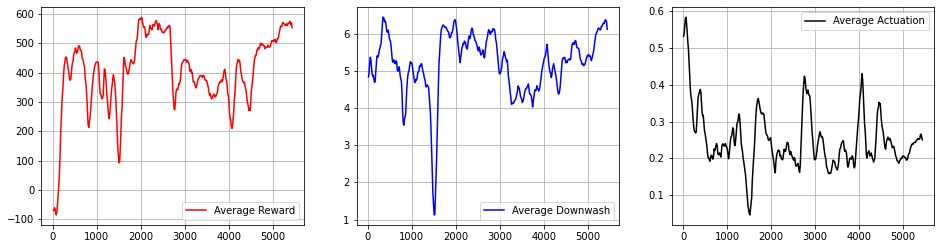

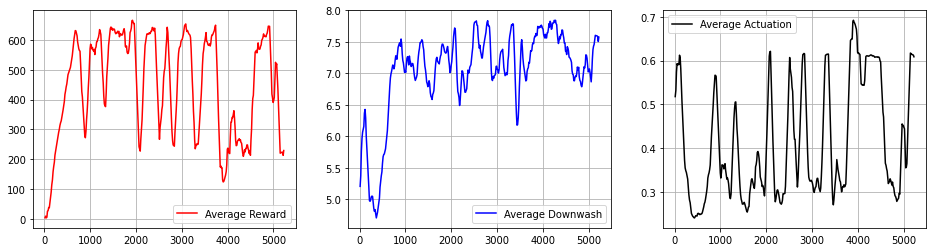

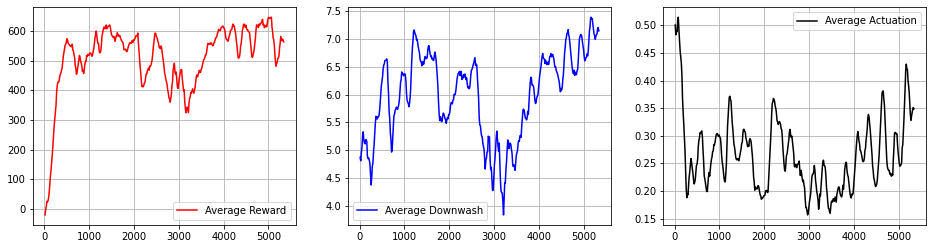

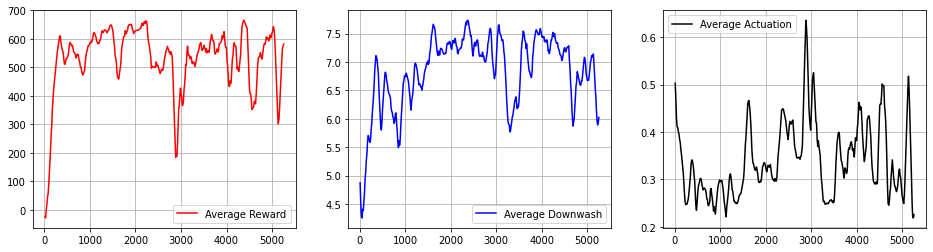

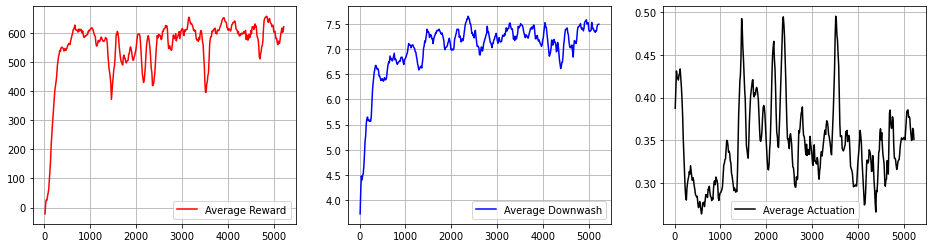

In [7]:
test_name = "act_cost_10_n_cells_1_1"

global_env_config = {
    "dt": 0.1,
    "xc": 9.0,
    "yc": 0.0,
    "sigma_x": 0.6,
    "sigma_y": 0.5,
    "gain": 0.25,
    "act_cost_weight": 10.0,
    "obs_min": [7.0, 0.1],
    "obs_max": [8.0, 0.5],
    "n_particles": 400,
    "lamb": 0.1,
    "n_cells": [1,1]
}

env_config = global_env_config.copy()

for random_seed in range(100,105):
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    lstm_cell_size = 16
    trainer_ppo_lstm_disc = PPOTrainer(
        config={
            "env": MultipleParticlesInFlowDiscrete,
            "env_config": env_config,
            "framework": "torch",
            "train_batch_size": 2*1024,
            "callbacks": MyCallbacks,
            # Parallel rollouts
    #         "num_workers": 8,
            "num_gpus": 1,
            "lr": 0.00005,
            "clip_param": 0.99,
            "log_level": "INFO",
            "model": {
                "use_lstm": True,
                "lstm_cell_size": lstm_cell_size,
                "lstm_use_prev_action": False,
                "lstm_use_prev_reward": False,
                "max_seq_len": 40,
                "fcnet_hiddens": [256, 256],
            },
        }
    )

    train_reward_hist_lstm_disc = []
    train_downwash_hist_lstm_disc = []
    train_actuation_hist_lstm_disc = []
    train_episodes_total_lstm_disc = []

    for i in range(400):
        results = trainer_ppo_lstm_disc.train()
        train_reward_hist_lstm_disc.append(results['episode_reward_mean'])
        train_downwash_hist_lstm_disc.append(results['custom_metrics']['reward_downwash_mean'])
        train_actuation_hist_lstm_disc.append(results['custom_metrics']['reward_actuation_mean'])
        train_episodes_total_lstm_disc.append(results['episodes_total'])
        print(f"i={i}; reward={results['episode_reward_mean']}; downwash={results['custom_metrics']['reward_downwash_mean']}; actuation={results['custom_metrics']['reward_actuation_mean']}; episodes={results['episodes_this_iter']}; total episodes={results['episodes_total']}")
        if i % 10 == 9:
            trainer_ppo_lstm_disc.save_checkpoint(trainer_ppo_lstm_disc.logdir)

    # Save results to file
    train_lstm_disc_results = {
        "train_reward": train_reward_hist_lstm_disc,
        "train_downwash": train_downwash_hist_lstm_disc,
        "train_actuation": train_actuation_hist_lstm_disc,
        "train_episodes": train_episodes_total_lstm_disc
    }

    filename = f"ray_results/ppo_lstm_discrete_{test_name}/train_results_{random_seed}.pkl"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as f:
        pickle.dump(train_lstm_disc_results, f)
    trainer_ppo_lstm_disc.save_checkpoint(f"ray_results/ppo_lstm_discrete_{test_name}")
    
    plot_results(train_episodes_total_lstm_disc, train_reward_hist_lstm_disc, train_downwash_hist_lstm_disc, train_actuation_hist_lstm_disc)
    

## PPO + LSTM - Discrete - W = 20

2022-05-08 08:09:53,950	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 08:09:53,950	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(RolloutWorker pid=7299) 2022-05-08 08:09:55,405	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=7299) 2022-05-08 08:09:55,405	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps a

(RolloutWorker pid=7298) 2022-05-08 08:09:56,669	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=7298) 
(RolloutWorker pid=7298) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.671, max=0.1, mean=-0.224),
(RolloutWorker pid=7298)   'action_logp': np.ndarray((1024,), dtype=float32, min=-1.148, max=-0.381, mean=-0.669),
(RolloutWorker pid=7298)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.565),
(RolloutWorker pid=7298)   'advantages': np.ndarray((1024,), dtype=float32, min=-678.789, max=175.189, mean=-199.418),
(RolloutWorker pid=7298)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=7298)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=7298)   'eps_id': np.ndarray((1024,), dtype=int64, min=131898558.0, max=1734639566.0, mean=1046744381.053),
(RolloutWorker pid=7298)   'infos': np.ndarray((1024,), dtype=object, head={}),
(Rol

i=0; reward=-885.2469301459026; downwash=5.181555454306911; actuation=0.5479863018494375; episodes=12; total episodes=12
i=1; reward=-845.6703793490552; downwash=4.773389411320944; actuation=0.5195135441948744; episodes=14; total episodes=26
i=2; reward=-754.007295920061; downwash=4.512458526568219; actuation=0.47668714978013665; episodes=14; total episodes=40
i=3; reward=-684.7348652441246; downwash=4.2308807703624955; actuation=0.4404227406172057; episodes=14; total episodes=54
i=4; reward=-600.0293792257621; downwash=3.9298616838495035; actuation=0.39732893846748696; episodes=14; total episodes=68
i=5; reward=-526.5861211344044; downwash=3.5803550695766524; actuation=0.35572113412228723; episodes=14; total episodes=82
i=6; reward=-465.40359478855515; downwash=3.254284655158249; actuation=0.3191373497030914; episodes=14; total episodes=96
i=7; reward=-354.5046661771935; downwash=2.872474164189877; actuation=0.2636378609755073; episodes=14; total episodes=110
i=8; reward=-231.79862164

i=67; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=964
i=68; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=979
i=69; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=993
i=70; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=1007
i=71; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=1021
i=72; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=1035
i=73; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=1049
i=74; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=1064
i=75; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=1079
i=76; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=1093
i=77; reward=-0.19969897623578864; downwash=2.0477807089212936e-06; actuation=6.802721088435374e-05; episodes=14; total episodes=1107
i=78; reward=-0.19969897623578864; downwash=2.0477807089212936e-06; a

i=148; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2122
i=149; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=2137
i=150; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=2152
i=151; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2166
i=152; reward=-9.788399712764745; downwash=0.05140136972827768; actuation=0.0060499751482129705; episodes=14; total episodes=2180
i=153; reward=-13.582116950372045; downwash=0.08835048809296817; actuation=0.009220877646763033; episodes=14; total episodes=2194
i=154; reward=-11.612808617398443; downwash=0.17848829584652637; actuation=0.013026053640561603; episodes=15; total episodes=2209
i=155; reward=-9.316427389857374; downwash=0.2614867003173885; actuation=0.016401825998013705; episodes=14; total episodes=2223
i=156; reward=-6.661965266551996; downwash=0.3391050612724975; actuation=0.01937287751759281; episodes=14; total episodes=2237
i=157; reward=-5.48420029406617

i=230; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=3295
i=231; reward=-19.505607096814437; downwash=0.23807575949344278; actuation=0.018665924172509056; episodes=15; total episodes=3310
i=232; reward=-43.54630176032233; downwash=0.5064778670547311; actuation=0.0403030427230326; episodes=14; total episodes=3324
i=233; reward=-65.10034586298248; downwash=0.7462453633016218; actuation=0.05973267368621585; episodes=13; total episodes=3337
i=234; reward=-88.15346203883126; downwash=1.0022840076205546; actuation=0.08049377034942472; episodes=15; total episodes=3352
i=235; reward=-106.31190603599671; downwash=1.2388913714013565; actuation=0.09866889949924244; episodes=14; total episodes=3366
i=236; reward=-124.93083113423589; downwash=1.46389225695644; actuation=0.11633611613757258; episodes=14; total episodes=3380
i=237; reward=-146.13407302647246; downwash=1.7336114682458932; actuation=0.13712726275196258; episodes=14; total episodes=3394
i=238; reward=-150.75712954

i=295; reward=16.480738313920483; downwash=2.7273526909834116; actuation=0.13102431555385752; episodes=14; total episodes=4218
i=296; reward=22.633348813815896; downwash=2.721979171399493; actuation=0.12863570750146358; episodes=14; total episodes=4232
i=297; reward=16.922250881186987; downwash=2.768614635974826; actuation=0.13294149889673146; episodes=14; total episodes=4246
i=298; reward=13.383300905696139; downwash=2.7666449820151087; actuation=0.1340265169288456; episodes=14; total episodes=4260
i=299; reward=21.178574313055314; downwash=2.8188031105426954; actuation=0.13402096268231709; episodes=14; total episodes=4274
i=300; reward=27.272884515556438; downwash=2.919796472163892; actuation=0.13713094449021368; episodes=13; total episodes=4287
i=301; reward=32.903531374587914; downwash=3.001421026878723; actuation=0.1392914678329074; episodes=14; total episodes=4301
i=302; reward=39.06864281067857; downwash=3.0080358725990766; actuation=0.13754290253604357; episodes=14; total episo

i=361; reward=235.09247478716424; downwash=4.787859280561366; actuation=0.16217462807516522; episodes=14; total episodes=5123
i=362; reward=237.12370587111621; downwash=4.555470962058625; actuation=0.14987222761942726; episodes=14; total episodes=5137
i=363; reward=223.59085831036805; downwash=4.177453569868083; actuation=0.1352599462328945; episodes=14; total episodes=5151
i=364; reward=209.89777931834524; downwash=3.95872390980161; actuation=0.1286660536994729; episodes=13; total episodes=5164
i=365; reward=204.20386558955346; downwash=3.8490372130170267; actuation=0.12459141408227813; episodes=14; total episodes=5178
i=366; reward=202.77204833524218; downwash=3.735165469523829; actuation=0.11954852285899582; episodes=14; total episodes=5192
i=367; reward=211.9774615140093; downwash=3.871596275638371; actuation=0.1232327235094175; episodes=14; total episodes=5206
i=368; reward=214.62048833936262; downwash=4.014754888107994; actuation=0.12932836239504641; episodes=14; total episodes=5

2022-05-08 08:46:25,893	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 08:46:25,893	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=246.9805156449473; downwash=6.468561555137402; actuation=0.24201937294324258; episodes=14; total episodes=5639


2022-05-08 08:46:27,383	INFO worker_set.py:154 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([0.], [1.], (1,), float64), Discrete(2)), '__env__': (Box([0.], [1.], (1,), float64), Discrete(2))}
2022-05-08 08:46:27,388	INFO torch_policy.py:206 -- TorchPolicy (worker=local) running on 1 GPU(s).
2022-05-08 08:46:27,400	INFO rollout_worker.py:1727 -- Built policy map: {}
2022-05-08 08:46:27,400	INFO rollout_worker.py:1728 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7efec01fdb80>}
2022-05-08 08:46:27,401	INFO rollout_worker.py:666 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7efec01fda60>}
2022-05-08 08:46:27,405	WARNING util.py:60 -- Install gputil for GPU system monitoring.
(RolloutWorker pid=7944) 2022-05-08 08:46:27,344	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments.

(RolloutWorker pid=7944) 2022-05-08 08:46:28,584	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=7944) 
(RolloutWorker pid=7944) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.366, max=0.104, mean=-0.003),
(RolloutWorker pid=7944)   'action_logp': np.ndarray((1024,), dtype=float32, min=-0.919, max=-0.509, mean=-0.693),
(RolloutWorker pid=7944)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.508),
(RolloutWorker pid=7944)   'advantages': np.ndarray((1024,), dtype=float32, min=-581.447, max=356.855, mean=-150.713),
(RolloutWorker pid=7944)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=7944)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=7944)   'eps_id': np.ndarray((1024,), dtype=int64, min=301177826.0, max=1804540912.0, mean=947703273.557),
(RolloutWorker pid=7944)   'infos': np.ndarray((1024,), dtype=object, head={}),
(Ro

i=0; reward=-765.0490275939543; downwash=5.573804361278235; actuation=0.5280011745601332; episodes=12; total episodes=12
i=1; reward=-758.3839189188786; downwash=5.416881840494489; actuation=0.51865590999547; episodes=14; total episodes=26
i=2; reward=-676.0268815559515; downwash=4.662148811765274; actuation=0.45763028921765087; episodes=14; total episodes=40
i=3; reward=-580.3234063281083; downwash=4.1104895260408005; actuation=0.3997276036756311; episodes=14; total episodes=54
i=4; reward=-498.2911053752152; downwash=3.776903263470851; actuation=0.35606144563239456; episodes=14; total episodes=68
i=5; reward=-436.9013354193872; downwash=3.4440925920109215; actuation=0.3191338907517548; episodes=14; total episodes=82
i=6; reward=-383.46902048708085; downwash=3.120467277802614; actuation=0.2851627289990752; episodes=14; total episodes=96
i=7; reward=-295.12683550765774; downwash=2.4679332493109136; actuation=0.22351331016408305; episodes=15; total episodes=111
i=8; reward=-192.45021130

i=66; reward=-79.75311205560253; downwash=0.4256298230826433; actuation=0.048477706828680765; episodes=14; total episodes=954
i=67; reward=-135.9240263180484; downwash=0.9133976105230918; actuation=0.09204256450469331; episodes=14; total episodes=968
i=68; reward=-176.09214721040095; downwash=1.1219893967411199; actuation=0.11646929019039191; episodes=14; total episodes=982
i=69; reward=-179.34681503280066; downwash=1.1527026770237687; actuation=0.11910985045868942; episodes=15; total episodes=997
i=70; reward=-179.34681503280063; downwash=1.1527026770237687; actuation=0.11910985045868942; episodes=15; total episodes=1012
i=71; reward=-179.54672559265882; downwash=1.1527033113510157; actuation=0.11918077244450503; episodes=14; total episodes=1026
i=72; reward=-179.94637710424874; downwash=1.1527058065027689; actuation=0.11932414346197677; episodes=14; total episodes=1040
i=73; reward=-100.19326504864624; downwash=0.7270759834201255; actuation=0.07084643663329598; episodes=14; total epi

i=139; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=1997
i=140; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=2012
i=141; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2026
i=142; reward=-14.314272927511388; downwash=0.14268339117800807; actuation=0.012135618695779043; episodes=14; total episodes=2040
i=143; reward=-189.90446996236892; downwash=0.8846511778306586; actuation=0.1045176147480273; episodes=12; total episodes=2052
i=144; reward=-321.86404890618553; downwash=1.644605351245804; actuation=0.18505944516208359; episodes=14; total episodes=2066
i=145; reward=-336.90338584685196; downwash=2.2373050536282375; actuation=0.21985187709697407; episodes=14; total episodes=2080
i=146; reward=-327.87177369987074; downwash=2.9013037104019697; actuation=0.2501301578017198; episodes=14; total episodes=2094
i=147; reward=-325.7321201502802; downwash=3.4790476390890035; actuation=0.2784249076061096; episodes=13; total episod

i=206; reward=272.45042738235594; downwash=5.572208533056733; actuation=0.1895639614250605; episodes=14; total episodes=2913
i=207; reward=265.8104125287553; downwash=5.687317209336289; actuation=0.19736479402066404; episodes=13; total episodes=2926
i=208; reward=278.1434040337979; downwash=5.7287120183551; actuation=0.19573210479982336; episodes=13; total episodes=2939
i=209; reward=257.75919777941704; downwash=5.892869701811182; actuation=0.21055317164648724; episodes=13; total episodes=2952
i=210; reward=279.98310275406914; downwash=6.259738646164618; actuation=0.2219385262310084; episodes=13; total episodes=2965
i=211; reward=287.4215350144252; downwash=6.51921523880148; actuation=0.2323186623267325; episodes=13; total episodes=2978
i=212; reward=281.3562358578391; downwash=6.462196991154064; actuation=0.23166276514100514; episodes=14; total episodes=2992
i=213; reward=281.9445238611208; downwash=6.316829456375189; actuation=0.2241852985345438; episodes=13; total episodes=3005
i=21

i=272; reward=291.6556650536565; downwash=5.007427386513622; actuation=0.15396544648157962; episodes=14; total episodes=3801
i=273; reward=283.18302499202764; downwash=4.844670411537562; actuation=0.1487960727566872; episodes=14; total episodes=3815
i=274; reward=276.0969794373295; downwash=4.952338093777616; actuation=0.15650552201332102; episodes=13; total episodes=3828
i=275; reward=260.0835480055374; downwash=4.814757013327996; actuation=0.15472435573566437; episodes=14; total episodes=3842
i=276; reward=255.70598253170064; downwash=4.724644868332677; actuation=0.15158671827293543; episodes=14; total episodes=3856
i=277; reward=259.56954819867514; downwash=4.766942264438785; actuation=0.15211624768678728; episodes=13; total episodes=3869
i=278; reward=189.17803354726337; downwash=5.022449303387762; actuation=0.18790803646027046; episodes=14; total episodes=3883
i=279; reward=64.34146343872429; downwash=5.399864800143107; actuation=0.24692189252031066; episodes=13; total episodes=38

i=341; reward=-0.15240534200502912; downwash=0.00032599080818473193; actuation=6.84931506849315e-05; episodes=14; total episodes=4777
i=342; reward=-0.15240534200502912; downwash=0.00032599080818473193; actuation=6.84931506849315e-05; episodes=14; total episodes=4791
i=343; reward=-0.15240534200502912; downwash=0.00032599080818473193; actuation=6.84931506849315e-05; episodes=14; total episodes=4805
i=344; reward=-0.15240534200502912; downwash=0.00032599080818473193; actuation=6.84931506849315e-05; episodes=15; total episodes=4820
i=345; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=4834
i=346; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=4849
i=347; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=4863
i=348; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=4877
i=349; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=4891
i=350; reward=1.9516708880769849; downwash=0.06214591498915

2022-05-08 09:23:02,692	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 09:23:02,693	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=2.9370663021275116; downwash=0.11670148282526963; actuation=0.004823562751373458; episodes=14; total episodes=5608


(RolloutWorker pid=8581) 2022-05-08 09:23:04,144	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=8581) 2022-05-08 09:23:04,144	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=8583) 2022-05-08 09:23:04,133	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrect

(RolloutWorker pid=8581) 2022-05-08 09:23:05,412	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=8581) 
(RolloutWorker pid=8581) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.207, max=0.003, mean=-0.164),
(RolloutWorker pid=8581)   'action_logp': np.ndarray((1024,), dtype=float32, min=-0.756, max=-0.631, mean=-0.693),
(RolloutWorker pid=8581)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.499),
(RolloutWorker pid=8581)   'advantages': np.ndarray((1024,), dtype=float32, min=-532.52, max=190.989, mean=-144.004),
(RolloutWorker pid=8581)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=8581)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=8581)   'eps_id': np.ndarray((1024,), dtype=int64, min=228752277.0, max=1838658102.0, mean=1138964712.943),
(RolloutWorker pid=8581)   'infos': np.ndarray((1024,), dtype=object, head={}),
(Ro

i=0; reward=-709.5401671584723; downwash=5.262440585518141; actuation=0.5046181128659754; episodes=12; total episodes=12
i=1; reward=-763.9058614487338; downwash=5.274440267250585; actuation=0.518766032505362; episodes=14; total episodes=26
i=2; reward=-790.7593124366546; downwash=5.517140774746745; actuation=0.5393138258847626; episodes=14; total episodes=40
i=3; reward=-791.4175853890839; downwash=5.6773777070483415; actuation=0.5461538827431333; episodes=13; total episodes=53
i=4; reward=-789.2204997227996; downwash=5.766423140642712; actuation=0.5490361561548663; episodes=14; total episodes=67
i=5; reward=-745.8431724679607; downwash=5.557965393221133; actuation=0.5247879570729137; episodes=14; total episodes=81
i=6; reward=-667.6913800774048; downwash=4.930326770534497; actuation=0.46827354182856473; episodes=14; total episodes=95
i=7; reward=-581.3309538219951; downwash=4.340978225074143; actuation=0.4095052587660073; episodes=14; total episodes=109
i=8; reward=-469.1149082214716

i=70; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=1009
i=71; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=1023
i=72; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=1038
i=73; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=1053
i=74; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=1067
i=75; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=1081
i=76; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=1096
i=77; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=1110
i=78; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=1124
i=79; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=1138
i=80; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=1153
i=81; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=1167
i=82; reward=0.0; downwash=0.0; actuatio

i=172; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2470
i=173; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2484
i=174; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2498
i=175; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2512
i=176; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=2527
i=177; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=2542
i=178; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2556
i=179; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2570
i=180; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2584
i=181; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2598
i=182; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=2613
i=183; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2627
i=184; reward=0.0; downwash=

i=265; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=3799
i=266; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=3813
i=267; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=3828
i=268; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=3842
i=269; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=3856
i=270; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=3870
i=271; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=3884
i=272; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=3898
i=273; reward=0.0; downwash=0.0; actuation=0.0; episodes=16; total episodes=3914
i=274; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=3928
i=275; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=3942
i=276; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=3956
i=277; reward=0.0; downwash=

i=348; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=4986
i=349; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=5000
i=350; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=5015
i=351; reward=-0.1662936418002312; downwash=0.00023570879859978098; actuation=6.993006993006993e-05; episodes=14; total episodes=5029
i=352; reward=-0.1662936418002312; downwash=0.00023570879859978098; actuation=6.993006993006993e-05; episodes=14; total episodes=5043
i=353; reward=-0.1662936418002312; downwash=0.00023570879859978098; actuation=6.993006993006993e-05; episodes=14; total episodes=5057
i=354; reward=-0.1662936418002312; downwash=0.00023570879859978098; actuation=6.993006993006993e-05; episodes=15; total episodes=5072
i=355; reward=-0.1662936418002312; downwash=0.00023570879859978098; actuation=6.993006993006993e-05; episodes=14; total episodes=5086
i=356; reward=-0.1662936418002312; downwash=0.00023570879859978098; actuation=6.9930069

2022-05-08 09:59:34,303	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 09:59:34,303	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=5716


(RolloutWorker pid=9225) 2022-05-08 09:59:35,721	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=9225) 2022-05-08 09:59:35,721	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=9225) 2022-05-08 09:59:35,751	INFO torch_policy.py:183 -- TorchPolicy (worker=2) running on CPU.
(RolloutWorker pid=9224) 2022-05-08 09:59:35,788	WARNING rollout_worker.py:498 -- We've added a module for checking enviro

(RolloutWorker pid=9224) 2022-05-08 09:59:37,076	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=9224) 
(RolloutWorker pid=9224) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.783, max=0.012, mean=-0.118),
(RolloutWorker pid=9224)   'action_logp': np.ndarray((1024,), dtype=float32, min=-1.035, max=-0.435, mean=-0.686),
(RolloutWorker pid=9224)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.487),
(RolloutWorker pid=9224)   'advantages': np.ndarray((1024,), dtype=float32, min=-583.703, max=217.271, mean=-174.032),
(RolloutWorker pid=9224)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=9224)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=9224)   'eps_id': np.ndarray((1024,), dtype=int64, min=306515097.0, max=1875768648.0, mean=1105655483.981),
(RolloutWorker pid=9224)   'infos': np.ndarray((1024,), dtype=object, head={}),
(R

i=0; reward=-754.9953420316147; downwash=4.764499587733257; actuation=0.4871112821454311; episodes=12; total episodes=12
i=1; reward=-716.1554451505742; downwash=4.765454294860474; actuation=0.47745972224934613; episodes=14; total episodes=26
i=2; reward=-717.0331682375648; downwash=4.735716366609188; actuation=0.4747820345163946; episodes=14; total episodes=40
i=3; reward=-631.9824530525703; downwash=4.477191231694523; actuation=0.43448320295049503; episodes=14; total episodes=54
i=4; reward=-548.4185662446904; downwash=4.333560033132806; actuation=0.3998555236480442; episodes=14; total episodes=68
i=5; reward=-480.83152209375083; downwash=4.250694123283175; actuation=0.37340783849395215; episodes=14; total episodes=82
i=6; reward=-418.3941034760201; downwash=4.158159317949889; actuation=0.34795019860557136; episodes=14; total episodes=96
i=7; reward=-324.6509475032293; downwash=4.044426816315836; actuation=0.3112702801078775; episodes=13; total episodes=109
i=8; reward=-209.764853753

i=65; reward=-0.317139702720566; downwash=0.0020590945157983724; actuation=0.0002082232893157263; episodes=14; total episodes=933
i=66; reward=-0.317139702720566; downwash=0.0020590945157983724; actuation=0.0002082232893157263; episodes=14; total episodes=947
i=67; reward=-0.317139702720566; downwash=0.0020590945157983724; actuation=0.0002082232893157263; episodes=15; total episodes=962
i=68; reward=-0.12948887628410113; downwash=0.0019767666920414715; actuation=0.0001415566226490596; episodes=15; total episodes=977
i=69; reward=0.04818244381189553; downwash=0.001824870910381585; actuation=7.352941176470588e-05; episodes=14; total episodes=991
i=70; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=1005
i=71; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=1019
i=72; reward=0.08024672532007766; downwash=0.0019064403082998482; actuation=6.802721088435374e-05; episodes=14; total episodes=1033
i=73; reward=0.08024672532007766; downwash=0.00190644030

i=133; reward=-824.4709043911629; downwash=4.138004648824992; actuation=0.48115648982755843; episodes=14; total episodes=1893
i=134; reward=-615.3803409758061; downwash=3.5547454037924084; actuation=0.3832902160664083; episodes=14; total episodes=1907
i=135; reward=-477.0997587789311; downwash=3.36623679821925; actuation=0.32836755374799176; episodes=13; total episodes=1920
i=136; reward=-300.3747101459232; downwash=3.05558435640106; actuation=0.2542193412794616; episodes=15; total episodes=1935
i=137; reward=-148.78989034708655; downwash=2.6887247564229795; actuation=0.18532593378500736; episodes=14; total episodes=1949
i=138; reward=-81.76850319671864; downwash=2.2438126481954073; actuation=0.14034645002533716; episodes=14; total episodes=1963
i=139; reward=-47.363219526349674; downwash=1.8406143465155147; actuation=0.10821338055183975; episodes=14; total episodes=1977
i=140; reward=-33.07802148344916; downwash=1.5322202683817443; actuation=0.08788261088740638; episodes=14; total epi

i=198; reward=155.6837540789537; downwash=2.364464276182089; actuation=0.0654352029025858; episodes=15; total episodes=2807
i=199; reward=137.76912979525076; downwash=2.1143576752614948; actuation=0.05875409121190638; episodes=14; total episodes=2821
i=200; reward=107.259693488609; downwash=1.6884104599573242; actuation=0.047889378469203284; episodes=14; total episodes=2835
i=201; reward=89.9808682107051; downwash=1.4388896583089428; actuation=0.04122457451865522; episodes=14; total episodes=2849
i=202; reward=69.53902410237396; downwash=1.1575946066875047; actuation=0.03409093474567259; episodes=14; total episodes=2863
i=203; reward=62.518718122598266; downwash=1.0112851148142203; actuation=0.029265742321608165; episodes=14; total episodes=2877
i=204; reward=56.53742050940711; downwash=0.9259414313521996; actuation=0.026978285076356755; episodes=14; total episodes=2891
i=205; reward=44.75669944558421; downwash=0.7436025546172196; actuation=0.021983728884729613; episodes=14; total epis

i=263; reward=131.15891288514112; downwash=2.091101384769; actuation=0.06008388260596633; episodes=14; total episodes=3722
i=264; reward=136.32908188098267; downwash=2.1565004541679276; actuation=0.061636716535767834; episodes=14; total episodes=3736
i=265; reward=138.74576638730855; downwash=2.247116837233515; actuation=0.06539933172163082; episodes=14; total episodes=3750
i=266; reward=143.69707280743094; downwash=2.3401452714830966; actuation=0.06841693601246353; episodes=14; total episodes=3764
i=267; reward=141.43104479743081; downwash=2.3810234657422593; actuation=0.07113028339058367; episodes=14; total episodes=3778
i=268; reward=142.42840665420115; downwash=2.424316038457967; actuation=0.07283098564776001; episodes=14; total episodes=3792
i=269; reward=139.11825004571995; downwash=2.378838005637104; actuation=0.07160188530466394; episodes=14; total episodes=3806
i=270; reward=132.68017905503143; downwash=2.318809683607109; actuation=0.07078923680254012; episodes=14; total episo

i=328; reward=227.98896469060935; downwash=3.880955303487279; actuation=0.1177105644010709; episodes=13; total episodes=4633
i=329; reward=224.24149022871396; downwash=3.748064985547491; actuation=0.1123722335269545; episodes=13; total episodes=4646
i=330; reward=220.64674891995807; downwash=3.5820090957369333; actuation=0.10507070735649443; episodes=14; total episodes=4660
i=331; reward=214.13399416109888; downwash=3.5925613151154865; actuation=0.10800245848010556; episodes=14; total episodes=4674
i=332; reward=230.3559850914835; downwash=3.8569751975893185; actuation=0.11557115842978959; episodes=14; total episodes=4688
i=333; reward=190.06845128341777; downwash=4.255310277857259; actuation=0.14875803591006537; episodes=14; total episodes=4702
i=334; reward=189.03721466449966; downwash=4.496145209525357; actuation=0.16154329057530997; episodes=12; total episodes=4714
i=335; reward=197.96897045947244; downwash=4.713131732783102; actuation=0.16990460492080153; episodes=14; total episod

i=394; reward=217.83181814211855; downwash=5.208411672808206; actuation=0.18764713477899295; episodes=14; total episodes=5533
i=395; reward=215.26724956199615; downwash=5.068633383880465; actuation=0.1817003490929516; episodes=13; total episodes=5546
i=396; reward=215.18450159841922; downwash=4.907443270673427; actuation=0.17364224932492572; episodes=13; total episodes=5559
i=397; reward=214.14551814674982; downwash=4.835903805511038; actuation=0.17041112136824627; episodes=14; total episodes=5573
i=398; reward=205.17895838417502; downwash=4.598422350634466; actuation=0.16125045345330083; episodes=14; total episodes=5587


2022-05-08 10:36:21,822	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 10:36:21,823	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=202.8360424255051; downwash=4.527510037129195; actuation=0.15849769747339196; episodes=14; total episodes=5601


2022-05-08 10:36:23,287	INFO worker_set.py:154 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([0.], [1.], (1,), float64), Discrete(2)), '__env__': (Box([0.], [1.], (1,), float64), Discrete(2))}
(RolloutWorker pid=9837) 2022-05-08 10:36:23,242	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=9837) 2022-05-08 10:36:23,242	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment wi

(RolloutWorker pid=9836) 2022-05-08 10:36:24,497	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=9836) 
(RolloutWorker pid=9836) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.31, max=1.031, mean=0.023),
(RolloutWorker pid=9836)   'action_logp': np.ndarray((1024,), dtype=float32, min=-1.41, max=-0.274, mean=-0.658),
(RolloutWorker pid=9836)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.375),
(RolloutWorker pid=9836)   'advantages': np.ndarray((1024,), dtype=float32, min=-503.868, max=203.818, mean=-113.467),
(RolloutWorker pid=9836)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=9836)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=9836)   'eps_id': np.ndarray((1024,), dtype=int64, min=291468551.0, max=1904028163.0, mean=831543412.006),
(RolloutWorker pid=9836)   'infos': np.ndarray((1024,), dtype=object, head={}),
(Rollo

i=0; reward=-535.9645359502397; downwash=3.7488300794891547; actuation=0.3665349876318536; episodes=12; total episodes=12
i=1; reward=-531.7441755944533; downwash=3.8355758020849207; actuation=0.3701829314665131; episodes=14; total episodes=26
i=2; reward=-532.7182192609673; downwash=4.0686261750023265; actuation=0.3818898305970535; episodes=14; total episodes=40
i=3; reward=-506.98902316452035; downwash=3.9281846279479757; actuation=0.3666800086886703; episodes=14; total episodes=54
i=4; reward=-443.79299987199886; downwash=3.5194235403550445; actuation=0.32522239121421676; episodes=14; total episodes=68
i=5; reward=-363.6443063988257; downwash=3.3665632992376837; actuation=0.2905894236480838; episodes=14; total episodes=82
i=6; reward=-292.1767010663341; downwash=3.4512794677196346; actuation=0.2707630442978533; episodes=14; total episodes=96
i=7; reward=-197.08568709117804; downwash=3.5091772066652442; actuation=0.2418091076587494; episodes=14; total episodes=110
i=8; reward=-113.97

i=73; reward=-170.66855398547813; downwash=1.2690540899701501; actuation=0.11780892289139501; episodes=14; total episodes=1051
i=74; reward=-24.7646629628872; downwash=0.4057062263123401; actuation=0.02863154873575048; episodes=15; total episodes=1066
i=75; reward=-0.37087836822168824; downwash=0.031895692414607685; actuation=0.0017354001177511827; episodes=14; total episodes=1080
i=76; reward=-0.5713667389967533; downwash=0.001600182932728671; actuation=0.000279747642917122; episodes=14; total episodes=1094
i=77; reward=-0.3998637984237833; downwash=9.459308544297585e-07; actuation=0.00013889558717144923; episodes=14; total episodes=1108
i=78; reward=-0.19993232385759083; downwash=4.6673201661496567e-07; actuation=6.896551724137931e-05; episodes=15; total episodes=1123
i=79; reward=-0.19993232385759083; downwash=4.6673201661496567e-07; actuation=6.896551724137931e-05; episodes=14; total episodes=1137
i=80; reward=-0.19993232385759083; downwash=4.6673201661496567e-07; actuation=6.89655

i=153; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=2197
i=154; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2211
i=155; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2225
i=156; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=2240
i=157; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2254
i=158; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2268
i=159; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2282
i=160; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2296
i=161; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=2311
i=162; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=2326
i=163; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2340
i=164; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=2354
i=165; reward=0.0; downwash=

i=230; reward=0.08708570048019207; downwash=0.001939768246487784; actuation=6.756756756756757e-05; episodes=14; total episodes=3296
i=231; reward=-0.21442128994103038; downwash=0.002583557807081465; actuation=0.0002014201953766821; episodes=15; total episodes=3311
i=232; reward=-0.3015069904212224; downwash=0.0006437895605936805; actuation=0.00013385262780911451; episodes=14; total episodes=3325
i=233; reward=-0.3015069904212224; downwash=0.0006437895605936805; actuation=0.00013385262780911451; episodes=14; total episodes=3339
i=234; reward=-0.3015069904212224; downwash=0.0006437895605936805; actuation=0.00013385262780911451; episodes=15; total episodes=3354
i=235; reward=-0.3015069904212224; downwash=0.0006437895605936805; actuation=0.00013385262780911451; episodes=14; total episodes=3368
i=236; reward=-0.3015069904212224; downwash=0.0006437895605936805; actuation=0.00013385262780911451; episodes=14; total episodes=3382
i=237; reward=-0.3015069904212224; downwash=0.0006437895605936805

i=298; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=4263
i=299; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=4277
i=300; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=4291
i=301; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=4306
i=302; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=4320
i=303; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=4334
i=304; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=4349
i=305; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=4363
i=306; reward=-0.2720336439427446; downwash=0.00504602973131007; actuation=0.00035340201646177856; episodes=14; total episodes=4377
i=307; reward=-0.27203364394274465; downwash=0.00504602973131007; actuation=0.0003534020164617785; episodes=15; total episodes=4392
i=308; reward=-0.27203364394274465; downwash=0.0050460297313100685; actuation=0.00035340

i=370; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=5291
i=371; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=5305
i=372; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=5319
i=373; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=5334
i=374; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=5348
i=375; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=5362
i=376; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=5376
i=377; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=5391
i=378; reward=0.0; downwash=0.0; actuation=0.0; episodes=15; total episodes=5406
i=379; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=5420
i=380; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=5434
i=381; reward=0.0; downwash=0.0; actuation=0.0; episodes=14; total episodes=5448
i=382; reward=0.0; downwash=

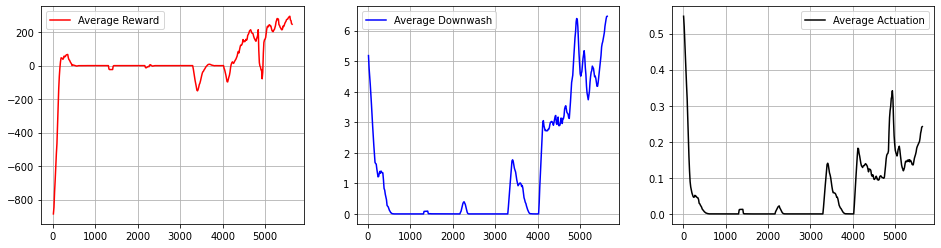

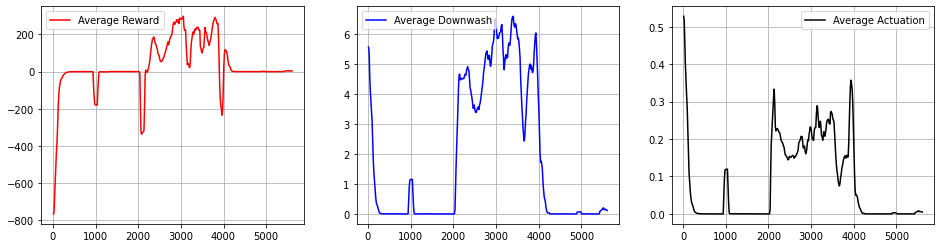

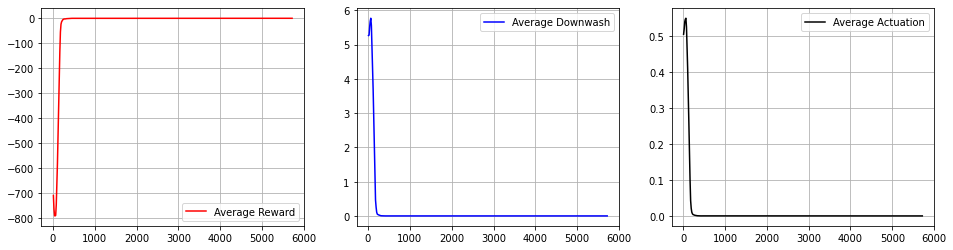

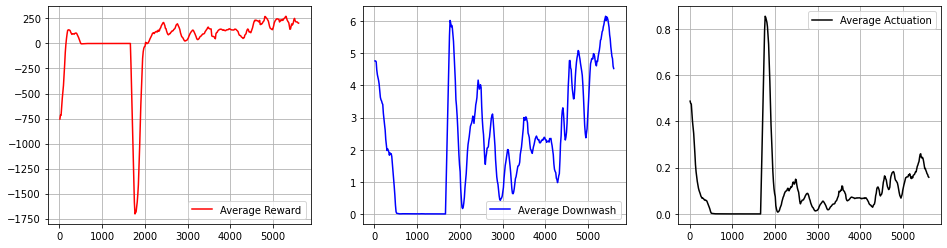

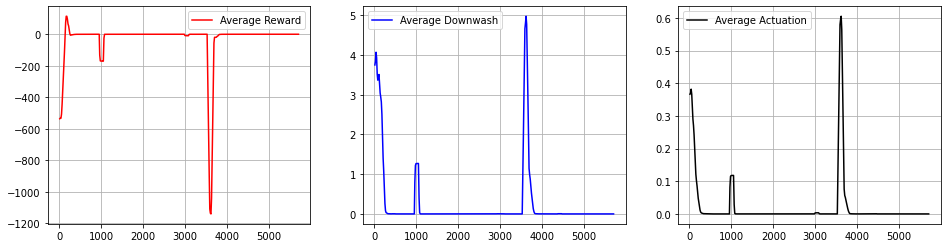

In [8]:
test_name = "act_cost_20_n_cells_1_1"

global_env_config = {
    "dt": 0.1,
    "xc": 9.0,
    "yc": 0.0,
    "sigma_x": 0.6,
    "sigma_y": 0.5,
    "gain": 0.25,
    "act_cost_weight": 20.0,
    "obs_min": [7.0, 0.1],
    "obs_max": [8.0, 0.5],
    "n_particles": 400,
    "lamb": 0.1,
    "n_cells": [1,1]
}

env_config = global_env_config.copy()

for random_seed in range(100,105):
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    lstm_cell_size = 16
    trainer_ppo_lstm_disc = PPOTrainer(
        config={
            "env": MultipleParticlesInFlowDiscrete,
            "env_config": env_config,
            "framework": "torch",
            "train_batch_size": 2*1024,
            "callbacks": MyCallbacks,
            # Parallel rollouts
    #         "num_workers": 8,
            "num_gpus": 1,
            "lr": 0.00005,
            "clip_param": 0.99,
            "log_level": "INFO",
            "model": {
                "use_lstm": True,
                "lstm_cell_size": lstm_cell_size,
                "lstm_use_prev_action": False,
                "lstm_use_prev_reward": False,
                "max_seq_len": 40,
                "fcnet_hiddens": [256, 256],
            },
        }
    )

    train_reward_hist_lstm_disc = []
    train_downwash_hist_lstm_disc = []
    train_actuation_hist_lstm_disc = []
    train_episodes_total_lstm_disc = []

    for i in range(400):
        results = trainer_ppo_lstm_disc.train()
        train_reward_hist_lstm_disc.append(results['episode_reward_mean'])
        train_downwash_hist_lstm_disc.append(results['custom_metrics']['reward_downwash_mean'])
        train_actuation_hist_lstm_disc.append(results['custom_metrics']['reward_actuation_mean'])
        train_episodes_total_lstm_disc.append(results['episodes_total'])
        print(f"i={i}; reward={results['episode_reward_mean']}; downwash={results['custom_metrics']['reward_downwash_mean']}; actuation={results['custom_metrics']['reward_actuation_mean']}; episodes={results['episodes_this_iter']}; total episodes={results['episodes_total']}")
        if i % 10 == 9:
            trainer_ppo_lstm_disc.save_checkpoint(trainer_ppo_lstm_disc.logdir)

    # Save results to file
    train_lstm_disc_results = {
        "train_reward": train_reward_hist_lstm_disc,
        "train_downwash": train_downwash_hist_lstm_disc,
        "train_actuation": train_actuation_hist_lstm_disc,
        "train_episodes": train_episodes_total_lstm_disc
    }

    filename = f"ray_results/ppo_lstm_discrete_{test_name}/train_results_{random_seed}.pkl"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as f:
        pickle.dump(train_lstm_disc_results, f)
    trainer_ppo_lstm_disc.save_checkpoint(f"ray_results/ppo_lstm_discrete_{test_name}")
    
    plot_results(train_episodes_total_lstm_disc, train_reward_hist_lstm_disc, train_downwash_hist_lstm_disc, train_actuation_hist_lstm_disc)
    

## PPO + LSTM - Discrete - W = 1

2022-05-08 11:41:57,396	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 11:41:57,397	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-05-08 11:41:58,882	INFO worker_set.py:154 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([0.], [1.], (1,), float64), Discrete(2)), '__env__': (Box([0.], [1.], (1,), float64), Discrete(2))}
2022-05-08 11:41:58,887	INFO torch_policy.py:206 -- TorchPolicy (worker=local) running on 1 GPU(s).
2022-05-08 11:41:58,910	INFO rollout_worker.py:1727 -- Built policy map: {}
2022-05-08 11:41:58,910	INFO rollout_worker.py:1728 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPre

(RolloutWorker pid=10965) 2022-05-08 11:42:00,138	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=10965) 
(RolloutWorker pid=10965) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.669, max=0.065, mean=-0.226),
(RolloutWorker pid=10965)   'action_logp': np.ndarray((1024,), dtype=float32, min=-1.106, max=-0.392, mean=-0.681),
(RolloutWorker pid=10965)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.533),
(RolloutWorker pid=10965)   'advantages': np.ndarray((1024,), dtype=float32, min=-4.969, max=627.519, mean=302.56),
(RolloutWorker pid=10965)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=10965)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=10965)   'eps_id': np.ndarray((1024,), dtype=int64, min=537118475.0, max=1912594930.0, mean=1416010998.564),
(RolloutWorker pid=10965)   'infos': np.ndarray((1024,), dtype=object, head={

i=0; reward=674.1574859077593; downwash=5.095699758268656; actuation=0.5431168838183642; episodes=12; total episodes=12
i=1; reward=676.0753536874106; downwash=5.1183327397339955; actuation=0.5731759162833107; episodes=14; total episodes=26
i=2; reward=684.0207641717445; downwash=5.160195526811867; actuation=0.5843288274891886; episodes=14; total episodes=40
i=3; reward=700.5291898825657; downwash=5.291244181794553; actuation=0.6130342844421519; episodes=14; total episodes=54
i=4; reward=719.8263032293444; downwash=5.452907219189872; actuation=0.6413196578724992; episodes=14; total episodes=68
i=5; reward=722.9577490949298; downwash=5.4933184554433065; actuation=0.660762667474431; episodes=13; total episodes=81
i=6; reward=717.7537053133873; downwash=5.4644285528128105; actuation=0.6638020179264312; episodes=13; total episodes=94
i=7; reward=741.0927216368276; downwash=5.6353728380570995; actuation=0.6887335378065533; episodes=14; total episodes=108
i=8; reward=764.1318020921937; downw

i=68; reward=1043.864233511392; downwash=7.526885449649028; actuation=0.8651591315171764; episodes=13; total episodes=897
i=69; reward=1042.3737302925626; downwash=7.52812120882163; actuation=0.8667076850029648; episodes=12; total episodes=909
i=70; reward=1041.6400184585652; downwash=7.524259975465487; actuation=0.876639340378248; episodes=14; total episodes=923
i=71; reward=1050.7079186592357; downwash=7.590909229030632; actuation=0.8699581001431375; episodes=12; total episodes=935
i=72; reward=1049.4680003654028; downwash=7.555526227442421; actuation=0.868364614945104; episodes=14; total episodes=949
i=73; reward=1049.0256377103065; downwash=7.5461213993983405; actuation=0.8696085858552514; episodes=12; total episodes=961
i=74; reward=1049.6012941731321; downwash=7.530114636349688; actuation=0.8764841928446961; episodes=12; total episodes=973
i=75; reward=1058.6914036347737; downwash=7.573855653242317; actuation=0.8940327066351051; episodes=14; total episodes=987
i=76; reward=1064.9

i=135; reward=1081.901472332404; downwash=7.829236505629009; actuation=0.9868622191814156; episodes=12; total episodes=1765
i=136; reward=1078.1848464912437; downwash=7.829909275817893; actuation=0.9845113259544253; episodes=14; total episodes=1779
i=137; reward=1082.5275947409934; downwash=7.873368865842183; actuation=0.9807781809316044; episodes=12; total episodes=1791
i=138; reward=1087.3251627785678; downwash=7.926790521885562; actuation=0.9774024895690219; episodes=14; total episodes=1805
i=139; reward=1085.1222254006075; downwash=7.923504999480914; actuation=0.9753516597600956; episodes=12; total episodes=1817
i=140; reward=1088.4467306640197; downwash=7.951765776666573; actuation=0.9742805622804682; episodes=14; total episodes=1831
i=141; reward=1088.0900542552254; downwash=7.929699473523956; actuation=0.9720626913681544; episodes=12; total episodes=1843
i=142; reward=1094.01688368606; downwash=7.954621594302792; actuation=0.9677709457360131; episodes=14; total episodes=1857
i=1

i=201; reward=1097.2372273773478; downwash=7.6420474707435275; actuation=0.671764554793342; episodes=12; total episodes=2617
i=202; reward=1099.84808179736; downwash=7.735227761775101; actuation=0.7299403024819898; episodes=13; total episodes=2630
i=203; reward=1092.9646723951373; downwash=7.734648012495775; actuation=0.792999284280736; episodes=13; total episodes=2643
i=204; reward=1095.1283890641496; downwash=7.800342863439207; actuation=0.8395896225608713; episodes=12; total episodes=2655
i=205; reward=1099.3324431494145; downwash=7.857949668394338; actuation=0.8742763488560935; episodes=13; total episodes=2668
i=206; reward=1098.9099762767237; downwash=7.871807705880891; actuation=0.9086543907846466; episodes=13; total episodes=2681
i=207; reward=1080.383939008804; downwash=7.756681963345216; actuation=0.9373674910092419; episodes=13; total episodes=2694
i=208; reward=1074.4576196537837; downwash=7.729731455865045; actuation=0.9529006189188258; episodes=13; total episodes=2707
i=20

i=267; reward=1088.82704346762; downwash=7.736070659961456; actuation=0.8046917818986291; episodes=12; total episodes=3470
i=268; reward=1089.561170656627; downwash=7.773826436024916; actuation=0.8284734772873952; episodes=14; total episodes=3484
i=269; reward=1088.7419042161755; downwash=7.776651179083256; actuation=0.8375447204054821; episodes=12; total episodes=3496
i=270; reward=1076.7645342657386; downwash=7.664140899284408; actuation=0.819604907953287; episodes=14; total episodes=3510
i=271; reward=1069.9161645084937; downwash=7.609123661045693; actuation=0.7853562240440773; episodes=12; total episodes=3522
i=272; reward=1060.6246277559624; downwash=7.5024676995455915; actuation=0.742354969822583; episodes=14; total episodes=3536
i=273; reward=1068.2301491778878; downwash=7.574102491996495; actuation=0.7317076798748713; episodes=13; total episodes=3549
i=274; reward=1057.718694514657; downwash=7.489523136637279; actuation=0.7247624093693203; episodes=12; total episodes=3561
i=275

i=333; reward=1068.2641765545795; downwash=7.713369557539763; actuation=0.9522451764023268; episodes=12; total episodes=4322
i=334; reward=1073.1763109863682; downwash=7.7498918138342425; actuation=0.9527799011093832; episodes=14; total episodes=4336
i=335; reward=1080.9487033001333; downwash=7.818322103243596; actuation=0.9530783262596654; episodes=12; total episodes=4348
i=336; reward=1069.8628536157703; downwash=7.732356468531504; actuation=0.9523835924765861; episodes=13; total episodes=4361
i=337; reward=1068.0982986324511; downwash=7.705763920670726; actuation=0.9533345268529554; episodes=13; total episodes=4374
i=338; reward=1067.8619413995154; downwash=7.697074937978715; actuation=0.9613130140092196; episodes=13; total episodes=4387
i=339; reward=1063.370398941975; downwash=7.675528009908529; actuation=0.9675659485030625; episodes=13; total episodes=4400
i=340; reward=1072.2126041581403; downwash=7.754734473488732; actuation=0.9739044356587736; episodes=12; total episodes=4412


2022-05-08 12:18:56,886	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 12:18:56,887	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=1082.0151686179627; downwash=7.626965958489661; actuation=0.812836986090326; episodes=12; total episodes=5172


(RolloutWorker pid=13386) 2022-05-08 12:18:58,957	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=13386) 2022-05-08 12:18:58,957	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=13385) 2022-05-08 12:18:58,957	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorr

(RolloutWorker pid=13385) 2022-05-08 12:19:00,233	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=13385) 
(RolloutWorker pid=13385) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.383, max=0.157, mean=0.007),
(RolloutWorker pid=13385)   'action_logp': np.ndarray((1024,), dtype=float32, min=-0.959, max=-0.483, mean=-0.692),
(RolloutWorker pid=13385)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.536),
(RolloutWorker pid=13385)   'advantages': np.ndarray((1024,), dtype=float32, min=-10.543, max=772.828, mean=337.523),
(RolloutWorker pid=13385)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=13385)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=13385)   'eps_id': np.ndarray((1024,), dtype=int64, min=64785107.0, max=1146002762.0, mean=648912760.735),
(RolloutWorker pid=13385)   'infos': np.ndarray((1024,), dtype=object, head={}

i=0; reward=718.8817375859568; downwash=5.322967093773973; actuation=0.53798977533038; episodes=12; total episodes=12
i=1; reward=739.3268108118233; downwash=5.4151611620617395; actuation=0.5242286932090809; episodes=14; total episodes=26
i=2; reward=763.7566107915881; downwash=5.540974731706584; actuation=0.531362282375104; episodes=14; total episodes=40
i=3; reward=791.693314641167; downwash=5.764347968767421; actuation=0.5549578695268349; episodes=13; total episodes=53
i=4; reward=822.4154210444043; downwash=5.963826488577947; actuation=0.5810885515829985; episodes=13; total episodes=66
i=5; reward=854.1577768401391; downwash=6.194710814305675; actuation=0.6048869615006021; episodes=14; total episodes=80
i=6; reward=861.4921765334269; downwash=6.2497167816548425; actuation=0.6107681271419968; episodes=12; total episodes=92
i=7; reward=883.8106343643208; downwash=6.411749357789687; actuation=0.6270204729404175; episodes=14; total episodes=106
i=8; reward=920.5889028885431; downwash=6

i=68; reward=964.7224609094271; downwash=6.926090031201841; actuation=0.6801627849439944; episodes=13; total episodes=900
i=69; reward=975.0270571497574; downwash=6.973164624803598; actuation=0.6481525976915624; episodes=13; total episodes=913
i=70; reward=967.9404516199618; downwash=6.905227613357231; actuation=0.6130188059328175; episodes=13; total episodes=926
i=71; reward=960.2385408544671; downwash=6.804811407504551; actuation=0.5679173844312225; episodes=14; total episodes=940
i=72; reward=963.2117594530538; downwash=6.773560947164836; actuation=0.5200069885015143; episodes=13; total episodes=953
i=73; reward=973.9900483600063; downwash=6.837759189183636; actuation=0.5045284775545885; episodes=13; total episodes=966
i=74; reward=978.6400091509151; downwash=6.830754135835075; actuation=0.4854499267581977; episodes=14; total episodes=980
i=75; reward=983.0879607640605; downwash=6.8439391074310185; actuation=0.480105708758886; episodes=12; total episodes=992
i=76; reward=992.2117981

i=135; reward=1099.3968191266822; downwash=7.966052612292293; actuation=0.9812729759026788; episodes=13; total episodes=1768
i=136; reward=1100.180268155969; downwash=7.98323020274136; actuation=0.9815546406402277; episodes=13; total episodes=1781
i=137; reward=1092.066089928216; downwash=7.906005278635206; actuation=0.9820851267869631; episodes=12; total episodes=1793
i=138; reward=1086.6376182163199; downwash=7.851570597663067; actuation=0.9819941085415792; episodes=14; total episodes=1807
i=139; reward=1082.2988552404722; downwash=7.82847616870991; actuation=0.9821186142840322; episodes=12; total episodes=1819
i=140; reward=1076.270488417994; downwash=7.783014822857106; actuation=0.981575136630183; episodes=13; total episodes=1832
i=141; reward=1068.754573656656; downwash=7.733723877427149; actuation=0.9808902428130419; episodes=13; total episodes=1845
i=142; reward=1079.1107092772734; downwash=7.811296320011503; actuation=0.9811864158368349; episodes=13; total episodes=1858
i=143; 

i=201; reward=1081.2464805651844; downwash=7.610077794837136; actuation=0.7516460190740635; episodes=12; total episodes=2614
i=202; reward=1075.6236758662992; downwash=7.522234328333882; actuation=0.7281052504733669; episodes=14; total episodes=2628
i=203; reward=1070.6097517724854; downwash=7.458975588655318; actuation=0.7027371084756444; episodes=12; total episodes=2640
i=204; reward=1073.8008132773857; downwash=7.4458263630304815; actuation=0.6752885392139141; episodes=13; total episodes=2653
i=205; reward=1050.760771704022; downwash=7.25295430944499; actuation=0.6342593542849059; episodes=13; total episodes=2666
i=206; reward=1028.828709496229; downwash=7.102502662605184; actuation=0.5904080085001742; episodes=14; total episodes=2680
i=207; reward=1025.5086398834255; downwash=7.059402268557606; actuation=0.5539355069899685; episodes=12; total episodes=2692
i=208; reward=1022.9471223171049; downwash=7.027919649518218; actuation=0.5132892495360925; episodes=14; total episodes=2706
i=

i=267; reward=1064.861443017816; downwash=7.769966643650077; actuation=0.9627319382729072; episodes=13; total episodes=3485
i=268; reward=1060.5070662494256; downwash=7.7136054435385795; actuation=0.9617489264846922; episodes=13; total episodes=3498
i=269; reward=1062.942351960162; downwash=7.725491574946955; actuation=0.9601815315808419; episodes=14; total episodes=3512
i=270; reward=1071.376312168517; downwash=7.811523423910805; actuation=0.9569062295347817; episodes=12; total episodes=3524
i=271; reward=1077.2227334426366; downwash=7.8505617020186165; actuation=0.9510670554853892; episodes=14; total episodes=3538
i=272; reward=1065.4595609562693; downwash=7.7434010191732385; actuation=0.9463826021252938; episodes=12; total episodes=3550
i=273; reward=1059.972553706946; downwash=7.700993212958617; actuation=0.9411059381069348; episodes=13; total episodes=3563
i=274; reward=1063.144579471174; downwash=7.72773869055908; actuation=0.9382573517694237; episodes=13; total episodes=3576
i=2

i=333; reward=1066.17757812767; downwash=7.694035371970198; actuation=0.9666512000502252; episodes=13; total episodes=4337
i=334; reward=1076.3231591252409; downwash=7.789465675726096; actuation=0.9614133078194119; episodes=13; total episodes=4350
i=335; reward=1086.271460453879; downwash=7.879018309638882; actuation=0.9555666071121135; episodes=13; total episodes=4363
i=336; reward=1087.8407359289954; downwash=7.888480677039889; actuation=0.9476476687355969; episodes=13; total episodes=4376
i=337; reward=980.7994869499722; downwash=7.108334367063821; actuation=0.8485761612809186; episodes=14; total episodes=4390
i=338; reward=951.164875728678; downwash=6.887970143740926; actuation=0.7904517265178878; episodes=13; total episodes=4403
i=339; reward=924.663189399038; downwash=6.701963776216272; actuation=0.7392175670595946; episodes=14; total episodes=4417
i=340; reward=881.884947085984; downwash=6.3553047746184825; actuation=0.6545968211234481; episodes=13; total episodes=4430
i=341; re

2022-05-08 12:55:50,643	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 12:55:50,643	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=1025.1235129622717; downwash=7.45632632831344; actuation=0.8859421456564056; episodes=12; total episodes=5194


(RolloutWorker pid=14114) 2022-05-08 12:55:52,408	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=14114) 2022-05-08 12:55:52,409	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=14115) 2022-05-08 12:55:52,408	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorr

(RolloutWorker pid=14114) 2022-05-08 12:55:53,678	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=14114) 
(RolloutWorker pid=14114) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.207, max=0.004, mean=-0.158),
(RolloutWorker pid=14114)   'action_logp': np.ndarray((1024,), dtype=float32, min=-0.755, max=-0.633, mean=-0.694),
(RolloutWorker pid=14114)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.484),
(RolloutWorker pid=14114)   'advantages': np.ndarray((1024,), dtype=float32, min=-4.526, max=646.63, mean=243.685),
(RolloutWorker pid=14114)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=14114)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=14114)   'eps_id': np.ndarray((1024,), dtype=int64, min=276580864.0, max=1649637116.0, mean=862624771.541),
(RolloutWorker pid=14114)   'infos': np.ndarray((1024,), dtype=object, head={}

i=0; reward=624.6524886885043; downwash=4.621977042671799; actuation=0.5026830711140731; episodes=12; total episodes=12
i=1; reward=665.6432701482875; downwash=4.97894878206446; actuation=0.5215319722411567; episodes=14; total episodes=26
i=2; reward=704.6763817345194; downwash=5.206629279321484; actuation=0.5317302705157256; episodes=14; total episodes=40
i=3; reward=729.7045739712194; downwash=5.389098719478652; actuation=0.5474053651348946; episodes=13; total episodes=53
i=4; reward=758.9579982567514; downwash=5.596603542858329; actuation=0.5590260844182963; episodes=14; total episodes=67
i=5; reward=772.7331248981341; downwash=5.6927375099269755; actuation=0.5690854580075004; episodes=14; total episodes=81
i=6; reward=779.6019425321088; downwash=5.733501951961141; actuation=0.575980763196459; episodes=12; total episodes=93
i=7; reward=809.8016170476797; downwash=5.929037082797123; actuation=0.5971960323541404; episodes=14; total episodes=107
i=8; reward=845.6630268018972; downwash=

i=68; reward=1014.3671511159486; downwash=6.937215712565879; actuation=0.3847711791193369; episodes=14; total episodes=899
i=69; reward=1010.2267786381452; downwash=6.9141918175093595; actuation=0.3885844355868974; episodes=13; total episodes=912
i=70; reward=1001.2491000313847; downwash=6.857048246587757; actuation=0.38835384210775137; episodes=13; total episodes=925
i=71; reward=1002.5100295807315; downwash=6.85856576284438; actuation=0.39158308505870143; episodes=13; total episodes=938
i=72; reward=1006.3884459206539; downwash=6.9061693579800085; actuation=0.39203515057506416; episodes=13; total episodes=951
i=73; reward=1023.4024394545954; downwash=6.984722183081243; actuation=0.3968705846275131; episodes=13; total episodes=964
i=74; reward=1021.8997543720801; downwash=6.952304311416015; actuation=0.4060174652682413; episodes=13; total episodes=977
i=75; reward=1036.212792786769; downwash=7.050241580598071; actuation=0.44206867508691056; episodes=13; total episodes=990
i=76; reward

i=134; reward=1094.4212450220969; downwash=7.884329812592282; actuation=0.9565756493353783; episodes=13; total episodes=1752
i=135; reward=1103.1242704202816; downwash=7.966374177090529; actuation=0.9620055456806029; episodes=13; total episodes=1765
i=136; reward=1106.6530675015604; downwash=7.985277035850636; actuation=0.9640904767998022; episodes=13; total episodes=1778
i=137; reward=1100.9915972208926; downwash=7.9293204808639315; actuation=0.964406718761121; episodes=13; total episodes=1791
i=138; reward=1102.3322019022708; downwash=7.958755090243161; actuation=0.966673390746726; episodes=13; total episodes=1804
i=139; reward=1095.8525906331724; downwash=7.915301159326119; actuation=0.9670439283859119; episodes=13; total episodes=1817
i=140; reward=1088.1339670743682; downwash=7.850215491417133; actuation=0.9685829270238476; episodes=12; total episodes=1829
i=141; reward=1082.9580276974398; downwash=7.798654226682682; actuation=0.9723596415829929; episodes=13; total episodes=1842
i

i=200; reward=1093.8932946016216; downwash=7.934179873106326; actuation=0.9590973353125277; episodes=14; total episodes=2604
i=201; reward=1090.8953113050309; downwash=7.908455013056324; actuation=0.9588007468555412; episodes=12; total episodes=2616
i=202; reward=1084.1484783817439; downwash=7.85981163219937; actuation=0.959907789695199; episodes=14; total episodes=2630
i=203; reward=1084.3390471937057; downwash=7.850026137155403; actuation=0.9617154345232841; episodes=12; total episodes=2642
i=204; reward=1073.5522978189756; downwash=7.769745078880158; actuation=0.9505287862496119; episodes=13; total episodes=2655
i=205; reward=1071.8800902394778; downwash=7.772096667917041; actuation=0.9419845165211332; episodes=13; total episodes=2668
i=206; reward=1071.4628010304282; downwash=7.76515036247707; actuation=0.9338142569151282; episodes=13; total episodes=2681
i=207; reward=1073.0124782834444; downwash=7.772107194078952; actuation=0.9303581610173702; episodes=13; total episodes=2694
i=2

i=266; reward=1100.3754544728106; downwash=7.965411389864959; actuation=0.9781932633017686; episodes=13; total episodes=3453
i=267; reward=1101.8514741102397; downwash=7.984015449641407; actuation=0.9793456760577154; episodes=13; total episodes=3466
i=268; reward=1097.2087920256338; downwash=7.933118384481056; actuation=0.9794964437134829; episodes=13; total episodes=3479
i=269; reward=1091.7705643843242; downwash=7.894787294607527; actuation=0.9790119181791122; episodes=13; total episodes=3492
i=270; reward=1098.939272489913; downwash=7.986700977275145; actuation=0.9808496830966902; episodes=13; total episodes=3505
i=271; reward=1090.1291616360281; downwash=7.910679316350404; actuation=0.9808833198235095; episodes=12; total episodes=3517
i=272; reward=1083.3312347065016; downwash=7.840278390375648; actuation=0.9817289233452984; episodes=14; total episodes=3531
i=273; reward=1094.0152975198885; downwash=7.927781615863066; actuation=0.9828561234662166; episodes=12; total episodes=3543
i

i=332; reward=1062.371170122177; downwash=7.605025516734026; actuation=0.9754582239089987; episodes=13; total episodes=4302
i=333; reward=1061.6248603165564; downwash=7.592109912841655; actuation=0.9763411194507229; episodes=12; total episodes=4314
i=334; reward=1072.6261125319777; downwash=7.664496548616204; actuation=0.9772588187254556; episodes=13; total episodes=4327
i=335; reward=1075.4188492590142; downwash=7.703700122448651; actuation=0.9752357932654944; episodes=13; total episodes=4340
i=336; reward=1086.0791085028818; downwash=7.80277870677501; actuation=0.9707664084241432; episodes=14; total episodes=4354
i=337; reward=1090.4551240511867; downwash=7.839761529458197; actuation=0.9691925586169162; episodes=12; total episodes=4366
i=338; reward=1098.4581746579129; downwash=7.902684516512741; actuation=0.9699876792184675; episodes=13; total episodes=4379
i=339; reward=1104.660474074086; downwash=7.948021758543997; actuation=0.9693029983996805; episodes=13; total episodes=4392
i=3

i=398; reward=1083.2096669401067; downwash=7.77965644495518; actuation=0.9029556833001386; episodes=13; total episodes=5151


2022-05-08 13:33:08,669	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 13:33:08,669	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=1073.0176426359412; downwash=7.707588238061517; actuation=0.893529190627007; episodes=13; total episodes=5164


2022-05-08 13:33:10,208	INFO worker_set.py:154 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([0.], [1.], (1,), float64), Discrete(2)), '__env__': (Box([0.], [1.], (1,), float64), Discrete(2))}
2022-05-08 13:33:10,213	INFO torch_policy.py:206 -- TorchPolicy (worker=local) running on 1 GPU(s).
2022-05-08 13:33:10,225	INFO rollout_worker.py:1727 -- Built policy map: {}
2022-05-08 13:33:10,226	INFO rollout_worker.py:1728 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7efc302aa580>}
2022-05-08 13:33:10,226	INFO rollout_worker.py:666 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7efc302aa400>}
2022-05-08 13:33:10,230	WARNING util.py:60 -- Install gputil for GPU system monitoring.
(RolloutWorker pid=14761) 2022-05-08 13:33:10,162	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments

(RolloutWorker pid=14760) 2022-05-08 13:33:11,463	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=14760) 
(RolloutWorker pid=14760) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.746, max=-0.002, mean=-0.121),
(RolloutWorker pid=14760)   'action_logp': np.ndarray((1024,), dtype=float32, min=-1.012, max=-0.453, mean=-0.687),
(RolloutWorker pid=14760)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.479),
(RolloutWorker pid=14760)   'advantages': np.ndarray((1024,), dtype=float32, min=-8.86, max=682.189, mean=256.113),
(RolloutWorker pid=14760)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=14760)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=14760)   'eps_id': np.ndarray((1024,), dtype=int64, min=54386801.0, max=1940741370.0, mean=820100294.64),
(RolloutWorker pid=14760)   'infos': np.ndarray((1024,), dtype=object, head={})

i=0; reward=621.1336947682889; downwash=4.541322017653188; actuation=0.4828315353610071; episodes=12; total episodes=12
i=1; reward=684.2393048210545; downwash=5.028406255102295; actuation=0.5380138730033596; episodes=14; total episodes=26
i=2; reward=721.7951177024257; downwash=5.333703608818925; actuation=0.5766049278698784; episodes=14; total episodes=40
i=3; reward=751.224329035311; downwash=5.532448585406576; actuation=0.5911844229220617; episodes=13; total episodes=53
i=4; reward=760.6267618363041; downwash=5.628710847070341; actuation=0.6081969812031337; episodes=13; total episodes=66
i=5; reward=761.0730917205738; downwash=5.633111731286954; actuation=0.6161677046899505; episodes=14; total episodes=80
i=6; reward=763.9509529664505; downwash=5.656800814553252; actuation=0.6190636557364326; episodes=14; total episodes=94
i=7; reward=777.4892894963226; downwash=5.760650270607703; actuation=0.6368838396317612; episodes=12; total episodes=106
i=8; reward=803.9566540170624; downwash=

i=68; reward=1069.5307066013734; downwash=7.705664565677719; actuation=0.9499246863634254; episodes=13; total episodes=908
i=69; reward=1074.8293307281144; downwash=7.765658237794892; actuation=0.9583989423532355; episodes=13; total episodes=921
i=70; reward=1080.115145383715; downwash=7.808409074406605; actuation=0.9673606347289959; episodes=12; total episodes=933
i=71; reward=1074.8446578330777; downwash=7.801015298801026; actuation=0.9754160088742506; episodes=14; total episodes=947
i=72; reward=1069.6653451473962; downwash=7.754281066298408; actuation=0.9808751144282551; episodes=12; total episodes=959
i=73; reward=1068.9184146382818; downwash=7.770515731227638; actuation=0.9866697962597017; episodes=13; total episodes=972
i=74; reward=1060.9588605127979; downwash=7.708197024004459; actuation=0.9884665612064778; episodes=13; total episodes=985
i=75; reward=1070.8096672157228; downwash=7.777124652942089; actuation=0.990092837314371; episodes=13; total episodes=998
i=76; reward=1076.

i=135; reward=1074.5726022482525; downwash=7.765519882811549; actuation=0.9770291434833254; episodes=13; total episodes=1766
i=136; reward=1082.973134819642; downwash=7.819448427541301; actuation=0.9710925302375546; episodes=13; total episodes=1779
i=137; reward=1085.5820153267246; downwash=7.832413644491771; actuation=0.9648652685810645; episodes=13; total episodes=1792
i=138; reward=1086.4138997649318; downwash=7.822139107601612; actuation=0.9618333232635066; episodes=12; total episodes=1804
i=139; reward=1081.7285150821074; downwash=7.788490009782136; actuation=0.9605195651146553; episodes=13; total episodes=1817
i=140; reward=1090.9718408471576; downwash=7.856431835046258; actuation=0.9594538366437837; episodes=13; total episodes=1830
i=141; reward=1094.440619795566; downwash=7.880348348792859; actuation=0.9608706518834551; episodes=12; total episodes=1842
i=142; reward=1092.1675043622404; downwash=7.858175128971713; actuation=0.9670848103224795; episodes=14; total episodes=1856
i=

i=201; reward=1110.5285635146686; downwash=8.050306946905168; actuation=0.9751230172834763; episodes=14; total episodes=2611
i=202; reward=1114.5271661163572; downwash=8.084896419189741; actuation=0.9771738239331047; episodes=12; total episodes=2623
i=203; reward=1110.3956320688933; downwash=8.056393824272012; actuation=0.9782105809609731; episodes=13; total episodes=2636
i=204; reward=1108.7632839814803; downwash=8.016958796361312; actuation=0.9796013941004097; episodes=13; total episodes=2649
i=205; reward=1107.3488950029277; downwash=8.011074506428558; actuation=0.980082186997231; episodes=13; total episodes=2662
i=206; reward=1108.161730873843; downwash=8.01374628572377; actuation=0.9795760830404382; episodes=13; total episodes=2675
i=207; reward=1105.0573700392106; downwash=8.00745501599139; actuation=0.9819303449470795; episodes=12; total episodes=2687
i=208; reward=1096.490550707312; downwash=7.960338614973017; actuation=0.9858000517853202; episodes=14; total episodes=2701
i=209

i=267; reward=1080.9311551992419; downwash=7.780668784465199; actuation=0.9304906219906962; episodes=13; total episodes=3458
i=268; reward=1066.1653246434905; downwash=7.6543228744808145; actuation=0.9301588247168451; episodes=13; total episodes=3471
i=269; reward=1069.8299609858257; downwash=7.683847953506452; actuation=0.9297357288640571; episodes=13; total episodes=3484
i=270; reward=1064.3178066282335; downwash=7.626531167902757; actuation=0.9320799676406802; episodes=12; total episodes=3496
i=271; reward=1069.4913055530392; downwash=7.674156190477971; actuation=0.9378208784328359; episodes=13; total episodes=3509
i=272; reward=1064.881862122889; downwash=7.6431802175278225; actuation=0.9410780364821386; episodes=13; total episodes=3522
i=273; reward=1068.6015009733264; downwash=7.674343409458005; actuation=0.9408762706932365; episodes=13; total episodes=3535
i=274; reward=1064.2299618950049; downwash=7.622575577324823; actuation=0.9412221312731025; episodes=13; total episodes=3548

i=333; reward=1067.775158920425; downwash=7.689572262969366; actuation=0.9618925155147191; episodes=13; total episodes=4305
i=334; reward=1074.5424232119124; downwash=7.751243351396368; actuation=0.9618499042843146; episodes=13; total episodes=4318
i=335; reward=1079.5202194619374; downwash=7.790375879953575; actuation=0.9619103449885915; episodes=13; total episodes=4331
i=336; reward=1075.8694032363558; downwash=7.768783138242416; actuation=0.9578517279586061; episodes=12; total episodes=4343
i=337; reward=1066.765261646952; downwash=7.691879860288444; actuation=0.955484641171196; episodes=13; total episodes=4356
i=338; reward=1058.1354614912234; downwash=7.604338615136197; actuation=0.9554586081624832; episodes=13; total episodes=4369
i=339; reward=1069.8072611569253; downwash=7.709976078846974; actuation=0.9615391595151279; episodes=12; total episodes=4381
i=340; reward=1078.9608602417625; downwash=7.773349160532617; actuation=0.9626428051759893; episodes=14; total episodes=4395
i=3

2022-05-08 14:10:56,809	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 14:10:56,810	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


i=399; reward=1076.949951628737; downwash=7.760075012100429; actuation=0.9692637199880793; episodes=13; total episodes=5154


(RolloutWorker pid=17151) 2022-05-08 14:10:58,290	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=17151) 2022-05-08 14:10:58,290	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=17152) 2022-05-08 14:10:58,291	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorr

(RolloutWorker pid=17151) 2022-05-08 14:10:59,552	INFO rollout_worker.py:854 -- Completed sample batch:
(RolloutWorker pid=17151) 
(RolloutWorker pid=17151) { 'action_dist_inputs': np.ndarray((1024, 2), dtype=float32, min=-0.31, max=1.037, mean=0.014),
(RolloutWorker pid=17151)   'action_logp': np.ndarray((1024,), dtype=float32, min=-1.426, max=-0.274, mean=-0.661),
(RolloutWorker pid=17151)   'actions': np.ndarray((1024,), dtype=int32, min=0.0, max=1.0, mean=0.377),
(RolloutWorker pid=17151)   'advantages': np.ndarray((1024,), dtype=float32, min=-2.83, max=552.159, mean=208.991),
(RolloutWorker pid=17151)   'agent_index': np.ndarray((1024,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=17151)   'dones': np.ndarray((1024,), dtype=bool, min=0.0, max=1.0, mean=0.006),
(RolloutWorker pid=17151)   'eps_id': np.ndarray((1024,), dtype=int64, min=45143964.0, max=1954003579.0, mean=887635441.755),
(RolloutWorker pid=17151)   'infos': np.ndarray((1024,), dtype=object, head={}),


i=0; reward=510.8469156146072; downwash=3.850615179593644; actuation=0.3871994720014536; episodes=12; total episodes=12
i=1; reward=573.2506567767997; downwash=4.291583351065824; actuation=0.428595259090505; episodes=14; total episodes=26
i=2; reward=575.0611754119093; downwash=4.3238889557371705; actuation=0.4322321709129554; episodes=14; total episodes=40
i=3; reward=560.0509415354959; downwash=4.2074173588386445; actuation=0.4235587990830919; episodes=14; total episodes=54
i=4; reward=563.6423036665632; downwash=4.230176571269704; actuation=0.4242416833324465; episodes=14; total episodes=68
i=5; reward=586.7602780397993; downwash=4.391901999738307; actuation=0.4373325867488275; episodes=14; total episodes=82
i=6; reward=620.6487905519788; downwash=4.630007985126605; actuation=0.45926385428230915; episodes=14; total episodes=96
i=7; reward=662.0394087681866; downwash=4.913745531595405; actuation=0.48686849885555156; episodes=13; total episodes=109
i=8; reward=697.7573808923163; downw

i=68; reward=1031.5054202077758; downwash=7.266425644446734; actuation=0.7026644116690224; episodes=14; total episodes=908
i=69; reward=1022.8037484529331; downwash=7.202721252976977; actuation=0.6879264210046607; episodes=12; total episodes=920
i=70; reward=1023.605355972974; downwash=7.221224541910503; actuation=0.7042566144443569; episodes=14; total episodes=934
i=71; reward=1033.4999688474888; downwash=7.323120654129295; actuation=0.7264981176239305; episodes=12; total episodes=946
i=72; reward=1039.0404610256899; downwash=7.366759198945833; actuation=0.7554823612524815; episodes=13; total episodes=959
i=73; reward=1033.462457426095; downwash=7.303941297482692; actuation=0.7663476349042904; episodes=13; total episodes=972
i=74; reward=1049.044788643571; downwash=7.442338584248396; actuation=0.7721850599935896; episodes=13; total episodes=985
i=75; reward=1055.0656367646206; downwash=7.4893518030101145; actuation=0.7827116085773566; episodes=13; total episodes=998
i=76; reward=1063.

i=135; reward=1001.281937552224; downwash=7.256917054172825; actuation=0.8620147242656678; episodes=14; total episodes=1787
i=136; reward=990.6980226598063; downwash=7.176106512860302; actuation=0.8442448866872612; episodes=12; total episodes=1799
i=137; reward=991.7646710453821; downwash=7.193379659065894; actuation=0.8306368072053538; episodes=14; total episodes=1813
i=138; reward=998.9535703849417; downwash=7.264758843900894; actuation=0.8233098106549328; episodes=13; total episodes=1826
i=139; reward=990.7257731549714; downwash=7.193692761184844; actuation=0.8174214661595168; episodes=13; total episodes=1839
i=140; reward=988.4674141209647; downwash=7.165990151043883; actuation=0.8170422250168466; episodes=12; total episodes=1851
i=141; reward=993.0153751744085; downwash=7.1937282569421255; actuation=0.8276895146490928; episodes=13; total episodes=1864
i=142; reward=1010.8301096137939; downwash=7.332325851531178; actuation=0.8465321306239221; episodes=13; total episodes=1877
i=143;

i=201; reward=1012.4063073422649; downwash=7.365869482055811; actuation=0.8792887416369889; episodes=12; total episodes=2644
i=202; reward=1006.2398440654354; downwash=7.312093542361772; actuation=0.8745975604742863; episodes=13; total episodes=2657
i=203; reward=1001.4249717559985; downwash=7.281455996849917; actuation=0.8727918729985217; episodes=13; total episodes=2670
i=204; reward=995.6737774088823; downwash=7.241702816475809; actuation=0.8737404144531692; episodes=13; total episodes=2683
i=205; reward=1001.3765821769043; downwash=7.289247872799258; actuation=0.8784754658616317; episodes=12; total episodes=2695
i=206; reward=1019.5149035925461; downwash=7.411266304161142; actuation=0.8951321123784319; episodes=14; total episodes=2709
i=207; reward=1033.7513502705028; downwash=7.491978229718328; actuation=0.9142823545044811; episodes=12; total episodes=2721
i=208; reward=1049.1106077791944; downwash=7.604677486803059; actuation=0.9354533938728328; episodes=14; total episodes=2735
i

i=267; reward=995.752737702769; downwash=7.231733487198813; actuation=0.8821623772092225; episodes=13; total episodes=3500
i=268; reward=1005.0083648007776; downwash=7.2984071739249465; actuation=0.8806659896850513; episodes=14; total episodes=3514
i=269; reward=992.128371278236; downwash=7.193750065333274; actuation=0.8797314097169974; episodes=12; total episodes=3526
i=270; reward=1001.1370305665123; downwash=7.269293011703668; actuation=0.8819062136292679; episodes=13; total episodes=3539
i=271; reward=1006.5698223370833; downwash=7.3158195501220655; actuation=0.8919994772954959; episodes=13; total episodes=3552
i=272; reward=1039.47555971786; downwash=7.533209802048403; actuation=0.9210242547095023; episodes=14; total episodes=3566
i=273; reward=1071.0339026219547; downwash=7.7545576800826055; actuation=0.9563342790206381; episodes=12; total episodes=3578
i=274; reward=1084.9885572572782; downwash=7.872624463293027; actuation=0.9647681714290863; episodes=12; total episodes=3590
i=2

i=333; reward=1032.8686460230672; downwash=7.412977818698273; actuation=0.9128324992595502; episodes=12; total episodes=4349
i=334; reward=1027.580260671336; downwash=7.376406035869232; actuation=0.8956888082665632; episodes=14; total episodes=4363
i=335; reward=1018.7703231415658; downwash=7.32672479184022; actuation=0.8837738905601921; episodes=12; total episodes=4375
i=336; reward=1024.2117278165338; downwash=7.363745851325487; actuation=0.8711369624590769; episodes=14; total episodes=4389
i=337; reward=1021.5386586095785; downwash=7.33652869531239; actuation=0.8685882528856617; episodes=12; total episodes=4401
i=338; reward=1035.256413784639; downwash=7.448031906857909; actuation=0.865356282477896; episodes=13; total episodes=4414
i=339; reward=1031.736025999551; downwash=7.421398737324235; actuation=0.8763053619529327; episodes=13; total episodes=4427
i=340; reward=1036.0765427764463; downwash=7.441147083545513; actuation=0.8920804284898582; episodes=12; total episodes=4439
i=341;

i=399; reward=1083.7663412541015; downwash=7.827454736346237; actuation=0.9874205170814578; episodes=13; total episodes=5200


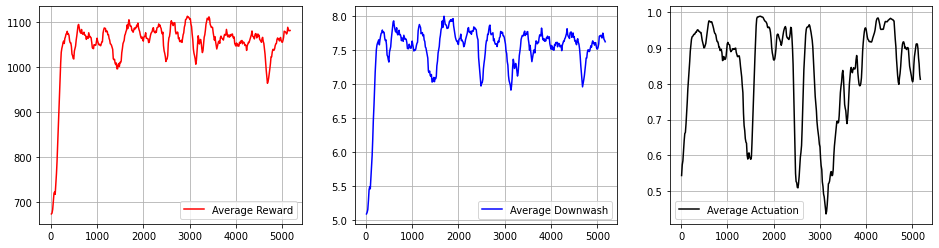

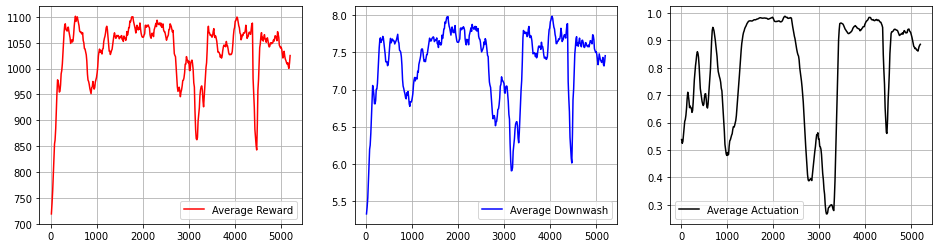

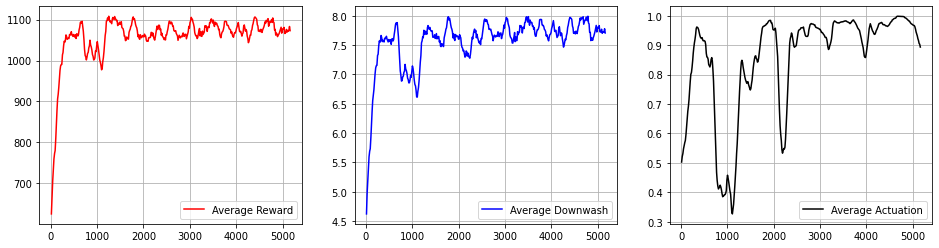

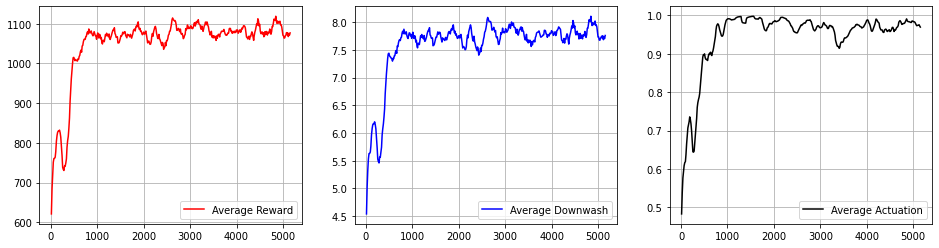

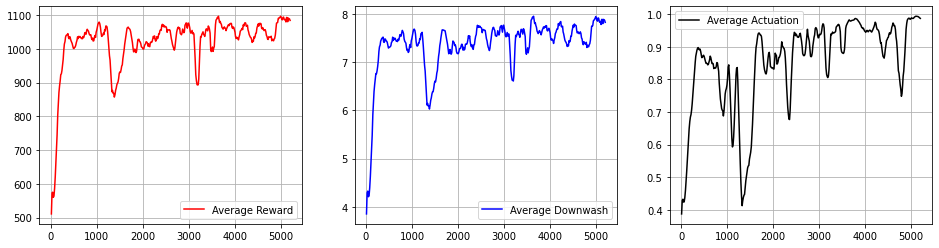

In [9]:
test_name = "act_cost_1_n_cells_1_1"

global_env_config = {
    "dt": 0.1,
    "xc": 9.0,
    "yc": 0.0,
    "sigma_x": 0.6,
    "sigma_y": 0.5,
    "gain": 0.25,
    "act_cost_weight": 1.0,
    "obs_min": [7.0, 0.1],
    "obs_max": [8.0, 0.5],
    "n_particles": 400,
    "lamb": 0.1,
    "n_cells": [1,1]
}

env_config = global_env_config.copy()

for random_seed in range(100,105):
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    lstm_cell_size = 16
    trainer_ppo_lstm_disc = PPOTrainer(
        config={
            "env": MultipleParticlesInFlowDiscrete,
            "env_config": env_config,
            "framework": "torch",
            "train_batch_size": 2*1024,
            "callbacks": MyCallbacks,
            # Parallel rollouts
    #         "num_workers": 8,
            "num_gpus": 1,
            "lr": 0.00005,
            "clip_param": 0.99,
            "log_level": "INFO",
            "model": {
                "use_lstm": True,
                "lstm_cell_size": lstm_cell_size,
                "lstm_use_prev_action": False,
                "lstm_use_prev_reward": False,
                "max_seq_len": 40,
                "fcnet_hiddens": [256, 256],
            },
        }
    )

    train_reward_hist_lstm_disc = []
    train_downwash_hist_lstm_disc = []
    train_actuation_hist_lstm_disc = []
    train_episodes_total_lstm_disc = []

    for i in range(400):
        results = trainer_ppo_lstm_disc.train()
        train_reward_hist_lstm_disc.append(results['episode_reward_mean'])
        train_downwash_hist_lstm_disc.append(results['custom_metrics']['reward_downwash_mean'])
        train_actuation_hist_lstm_disc.append(results['custom_metrics']['reward_actuation_mean'])
        train_episodes_total_lstm_disc.append(results['episodes_total'])
        print(f"i={i}; reward={results['episode_reward_mean']}; downwash={results['custom_metrics']['reward_downwash_mean']}; actuation={results['custom_metrics']['reward_actuation_mean']}; episodes={results['episodes_this_iter']}; total episodes={results['episodes_total']}")
        if i % 10 == 9:
            trainer_ppo_lstm_disc.save_checkpoint(trainer_ppo_lstm_disc.logdir)

    # Save results to file
    train_lstm_disc_results = {
        "train_reward": train_reward_hist_lstm_disc,
        "train_downwash": train_downwash_hist_lstm_disc,
        "train_actuation": train_actuation_hist_lstm_disc,
        "train_episodes": train_episodes_total_lstm_disc
    }

    filename = f"ray_results/ppo_lstm_discrete_{test_name}/train_results_{random_seed}.pkl"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as f:
        pickle.dump(train_lstm_disc_results, f)
    trainer_ppo_lstm_disc.save_checkpoint(f"ray_results/ppo_lstm_discrete_{test_name}")
    
    plot_results(train_episodes_total_lstm_disc, train_reward_hist_lstm_disc, train_downwash_hist_lstm_disc, train_actuation_hist_lstm_disc)
    